# HR-FOSI: Exploring relationship between barotropic inflow-outflow and DSL

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import dask
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
import os
%matplotlib inline

from mypyutils import calendar_utils as cal
from mypyutils import stat_utils as stat
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import io_utils as io
from mypyutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2023.7.0'

## Create Dask Cluster

In [82]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
client.shutdown()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        account='NCGD0011',
        walltime='02:00:00',
        local_directory='/glade/scratch/yeager/',
        log_directory='/glade/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": "1.0",
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [5]:
client

<Client: 'tcp://128.117.208.75:34293' processes=0 threads=0, memory=0 B>

# Main Processing

In [6]:
# N. Atlantic domain for HR
i0 = 0; i1 = 1350
j0 = 1150; j1 = 2310

#### Get HR-FOSI SSH

In [7]:
# Get monthly SSH
def preprocessor(d0):
    d0 = d0[['SSH']].isel(nlat=slice(j0,j1)).isel(nlon=slice(i0,i1))
    d0 = cal.time_set_midmonth(d0,'time')
    return d0

In [8]:
%%time
datadir = '/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI/HR/g.e21.GIAF.TL319_t13.5thCyc.ice.001/ocn/hist/'
fin = datadir+'g.e21.GIAF.TL319_t13.5thCyc.ice.001.pop.h.????-??.nc'

ds_ssh = xr.open_mfdataset(fin,combine='by_coords',coords="minimal",compat="override",
                       preprocess=preprocessor,
                       parallel=True,)

CPU times: user 20.7 s, sys: 1.71 s, total: 22.4 s
Wall time: 1min 45s


In [9]:
# Select sim-years 0245-0308
ds_ssh = ds_ssh.isel(time=slice(0,768))

In [10]:
nt = ds_ssh.dims['time']
years = ds_ssh.time.dt.year
mons = ds_ssh.time.dt.month
ds_ssh['time'] = [cftime.DatetimeNoLeap(years[i]+1713, mons[i], 15) for i in range(nt)]

#### Get HR-FOSI UVEL 

In [11]:
# Get monthly SSH
def preprocessor(d0):
    d0 = d0[['UVEL']].isel(nlat=slice(j0,j1)).isel(nlon=slice(i0,i1))
    d0 = cal.time_set_midmonth(d0,'time')
    return d0

In [12]:
%%time
datadir = '/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI/HR/g.e21.GIAF.TL319_t13.5thCyc.ice.001/ocn/hist/'
fin = datadir+'g.e21.GIAF.TL319_t13.5thCyc.ice.001.pop.h.????-??.nc'

ds_uvel = xr.open_mfdataset(fin,combine='by_coords',coords="minimal",compat="override",
                       preprocess=preprocessor,
                       parallel=True,)

CPU times: user 15 s, sys: 1.05 s, total: 16 s
Wall time: 1min 7s


In [13]:
# Select sim-years 0245-0308
ds_uvel = ds_uvel.isel(time=slice(0,768))

In [14]:
nt = ds_uvel.dims['time']
years = ds_uvel.time.dt.year
mons = ds_uvel.time.dt.month
ds_uvel['time'] = [cftime.DatetimeNoLeap(years[i]+1713, mons[i], 15) for i in range(nt)]

#### Get HR-FOSI VVEL

In [15]:
def preprocessor(d0):
    d0 = d0[['VVEL']].isel(nlat=slice(j0,j1)).isel(nlon=slice(i0,i1))
    d0 = cal.time_set_midmonth(d0,'time')
    return d0

In [16]:
%%time
datadir = '/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI/HR/g.e21.GIAF.TL319_t13.5thCyc.ice.001/ocn/hist/'
fin = datadir+'g.e21.GIAF.TL319_t13.5thCyc.ice.001.pop.h.????-??.nc'

ds_vvel = xr.open_mfdataset(fin,combine='by_coords',coords="minimal",compat="override",
                       preprocess=preprocessor,
                       parallel=True,)

CPU times: user 17.2 s, sys: 1.21 s, total: 18.4 s
Wall time: 1min 22s


In [17]:
# Select sim-years 0245-0308
ds_vvel = ds_vvel.isel(time=slice(0,768))

In [18]:
nt = ds_vvel.dims['time']
years = ds_vvel.time.dt.year
mons = ds_vvel.time.dt.month
ds_vvel['time'] = [cftime.DatetimeNoLeap(years[i]+1713, mons[i], 15) for i in range(nt)]

#### Get HR-FOSI WVEL

In [19]:
def preprocessor(d0):
    d0 = d0[['WVEL']].isel(nlat=slice(j0,j1)).isel(nlon=slice(i0,i1)).isel(z_w_top=0)
    d0 = cal.time_set_midmonth(d0,'time')
    return d0

In [20]:
%%time
datadir = '/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI/HR/g.e21.GIAF.TL319_t13.5thCyc.ice.001/ocn/hist/'
fin = datadir+'g.e21.GIAF.TL319_t13.5thCyc.ice.001.pop.h.????-??.nc'

ds_wvel = xr.open_mfdataset(fin,combine='by_coords',coords="minimal",compat="override",
                       preprocess=preprocessor,
                       parallel=True,)

CPU times: user 16.4 s, sys: 1.09 s, total: 17.5 s
Wall time: 1min 15s


In [21]:
# Select sim-years 0245-0308
ds_wvel = ds_wvel.isel(time=slice(0,768))

In [22]:
nt = ds_wvel.dims['time']
years = ds_wvel.time.dt.year
mons = ds_wvel.time.dt.month
ds_wvel['time'] = [cftime.DatetimeNoLeap(years[i]+1713, mons[i], 15) for i in range(nt)]

#### Get HR-FOSI BSF

In [23]:
# Get monthly BSF
def preprocessor(d0):
    d0 = d0[['BSF']].isel(nlat=slice(j0,j1)).isel(nlon=slice(i0,i1))
    return d0

In [24]:
%%time
datadir = '/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI/HR/g.e21.GIAF.TL319_t13.5thCyc.ice.001/ocn/proc/month_1/'
fin = datadir+'g.e21.GIAF.TL319_t13.5thCyc.ice.001.pop.h.BSF.????.nc'
ds_bsf = xr.open_mfdataset(fin,combine='by_coords',coords="minimal",compat="override",
                       preprocess=preprocessor,
                       parallel=True,)

CPU times: user 314 ms, sys: 24.1 ms, total: 338 ms
Wall time: 670 ms


In [25]:
nt = ds_bsf.dims['time']
years = ds_bsf.time.dt.year
mons = ds_bsf.time.dt.month
ds_bsf['time'] = [cftime.DatetimeNoLeap(years[i]+1713, mons[i], 15) for i in range(nt)]

#### Get HR-FOSI MOC

In [26]:
fin = '/glade/work/yeager/cesm_output/HR_OMIP2-CMIP6/g.e20.G.TL319_t13.control.001.pop.h.0245-0308.MOCsig.nc'
ds_mocsig = xr.open_dataset(fin)
ds_mocsig['time'] = ds_mocsig['time']+1713

In [27]:
moc26 = ds_mocsig['MOC'].sel(lat_aux_grid=26.5,method='nearest').max('sigma').isel(transport_reg=1)
moc45 = ds_mocsig['MOC'].sel(lat_aux_grid=45,method='nearest').max('sigma').isel(transport_reg=1)

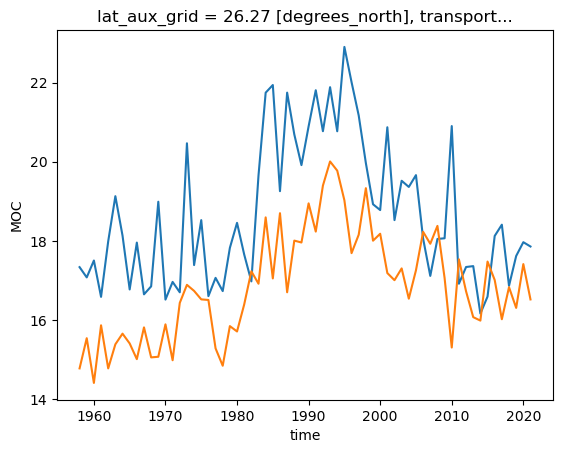

In [28]:
moc45.plot()
moc26.plot()

#### Get HR-FOSI Grid Info

In [29]:
%%time
# get POP grid
infile='/glade/work/fredc/metric/grid/POP_tx0.1v3_grid.nc'
dsg = xr.open_dataset(infile).isel(nlat=slice(j0,j1)).isel(nlon=slice(i0,i1))
hr_htn = dsg.HTN
hr_hte = dsg.HTE
hr_tarea = dsg.TAREA
hr_dzt = dsg.DZT
hr_dzu = dsg.DZU
hr_dxt = dsg.DXT
hr_dyt = dsg.DYT
hr_dxu = dsg.DXU
hr_dyu = dsg.DYU
hr_ht = dsg.HT
hr_lat = dsg.TLAT.fillna(0)
hr_lon = dsg.TLONG.fillna(0)
hr_kmt = dsg.KMT
hr_rmask = dsg.REGION_MASK

CPU times: user 93.7 ms, sys: 44 ms, total: 138 ms
Wall time: 573 ms


In [30]:
hr_lon = xr.where(hr_lon>180.,hr_lon-360,hr_lon)

In [31]:
natl_mask = (hr_lat>=0) & (hr_lat<=70) & ((hr_lon>=-100) & (hr_lon<=20)) & (hr_rmask != 2)

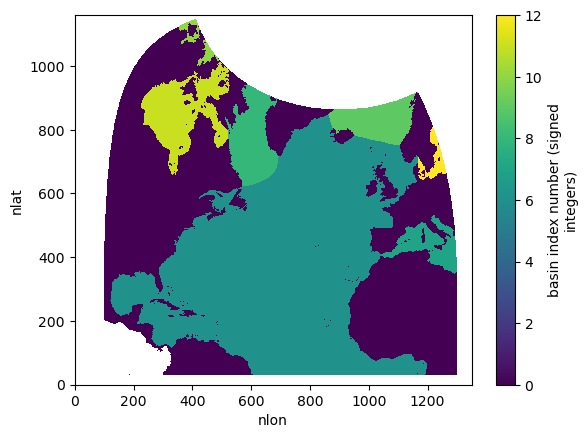

In [32]:
hr_rmask.where(natl_mask).plot()

#### Create GoM Mask

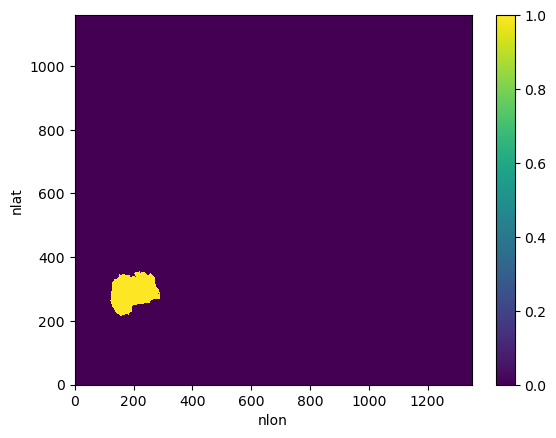

In [33]:
## GoM mask
lons1 = [-87,-84.6,-81,-81]
lats1 = [21.6,22,23.2,25.1]
slp1 = (lats1[1]-lats1[0])/(lons1[1]-lons1[0])
hr_gom = (hr_rmask==6) & (hr_lon<-81) 
hr_gom_fix1 = (hr_rmask==6) & (hr_lon>=-89) & (hr_lon<=-84) & ((hr_lat-lats1[0])>((hr_lon-lons1[0])*slp1))
fix1 = (hr_rmask==6) & (hr_lon>=-89) & (hr_lon<=-84)
hr_gom = xr.where(fix1, hr_gom_fix1,hr_gom)
slp2 = (23-22.5)/(-81-(-84))
hr_gom_fix3 = (hr_rmask==6) & (hr_lon>=-84) & (hr_lon<=-81) & ((hr_lat-(22.5))>((hr_lon-(-84))*slp2))
fix3 = (hr_rmask==6) & (hr_lon>=-84) & (hr_lon<=-81)
hr_gom = xr.where(fix3, hr_gom_fix3,hr_gom)
fix2 = (hr_rmask==6) & (hr_lon>=-82) & (hr_lat>=29)
hr_gom = xr.where(fix2, 0,hr_gom)
hr_gom.plot()

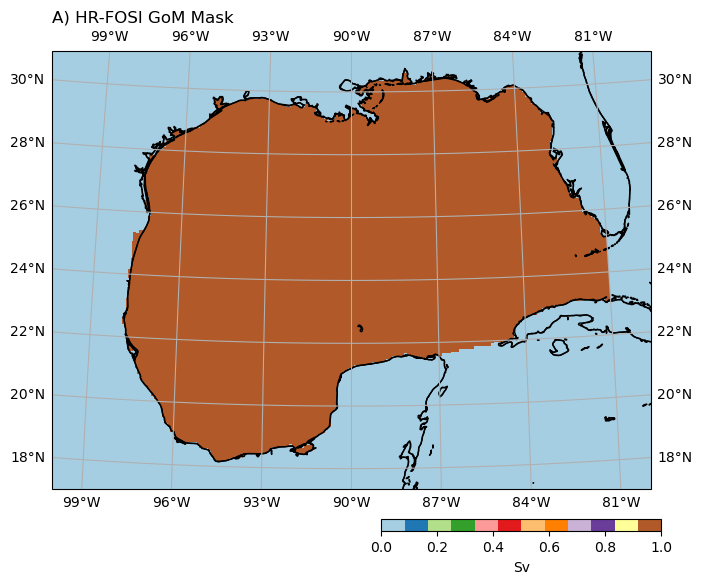

In [34]:
from matplotlib.colors import BoundaryNorm
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.Paired)
overclr = 'gold'
underclr = 'cyan'
lineclr = 'yellow'
lineclr2 = 'orange'
clevs = [-1,0,1]
norm = BoundaryNorm(clevs, ncolors=colmap.N, clip=False)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(8, 6))
ax2 = fig.add_subplot(1, 1, 1, projection=proj2)

#cntr2 = ax2.contourf(hr_lon, hr_lat, hr_gom, levels=[-1,0,1], cmap=colmap, transform=ccrs.PlateCarree())
cntr2 = ax2.pcolormesh(hr_lon, hr_lat, hr_gom, shading='nearest', cmap=colmap, rasterized=True, transform=ccrs.PlateCarree())
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('A) HR-FOSI GoM Mask',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,-80, 17, 31]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='Sv')

#### Create Barotropic Zonal & Meridional Transports and Barotropic Convergence

In [58]:
uvel = ds_uvel['UVEL']/100.   # m/s
uvel['z_t'] = hr_dzu['z_t']
su = (uvel*hr_dzu*hr_dyu)     # m^3/s
suann = su.isel(time=slice(120,None)).groupby('time.year').mean('time').rename({'year':'time'}).load()

vvel = ds_vvel['VVEL']/100.   # m/s
vvel['z_t'] = hr_dzu['z_t']
sv = (vvel*hr_dzu*hr_dxu)     # m^3/s
svann = su.isel(time=slice(120,None)).groupby('time.year').mean('time').rename({'year':'time'}).load()

KeyboardInterrupt: 

In [54]:
def fluxdiv_B(uflux,vflux):
    # B-grid divergence
    # Assumes uflux=U*DY*DZ, vflux=V*DX*DZ
    UTE = 0.5*(uflux+uflux.shift(nlat=1))
    UTW = UTE.roll(nlon=1,roll_coords=False)
    VTN = 0.5*(vflux+vflux.roll(nlon=1,roll_coords=False))
    VTS = VTN.shift(nlat=1)
    fluxdiv = (UTE-UTW+VTN-VTS)
    return fluxdiv

In [57]:
%%time
susv_conv = -fluxdiv_B(su,sv).sum('z_t')/1.e6
susv_conv = xr.where(hr_kmt==0,np.nan,susv_conv)
susv_conv.attrs['units']='Sv'
susv_conv = susv_conv.load()
susv_wvel = susv_conv/hr_tarea # m/s


KeyboardInterrupt



In [36]:
%%time
suann = su.sum('z_t').isel(time=slice(120,None)).groupby('time.year').mean('time').rename({'year':'time'}).load()
suann.attrs['units']='Sv'
svann = sv.sum('z_t').isel(time=slice(120,None)).groupby('time.year').mean('time').rename({'year':'time'}).load()
svann.attrs['units']='Sv'

CPU times: user 1min 27s, sys: 8.77 s, total: 1min 36s
Wall time: 7min


In [39]:
%%time
wvel = ds_wvel['WVEL']/100.   # m/s
wvelann = wvel.isel(time=slice(120,None)).groupby('time.year').mean('time').rename({'year':'time'}).load()

CPU times: user 16.6 s, sys: 1.5 s, total: 18.1 s
Wall time: 1min 10s


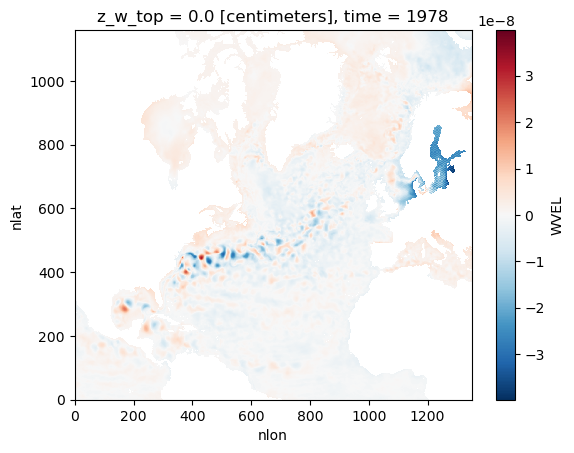

In [40]:
wvelann.isel(time=10).plot()

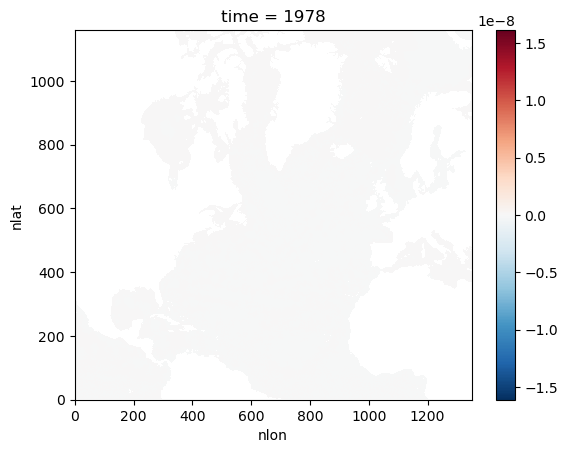

In [51]:
susv_wvel.isel(time=10).plot()

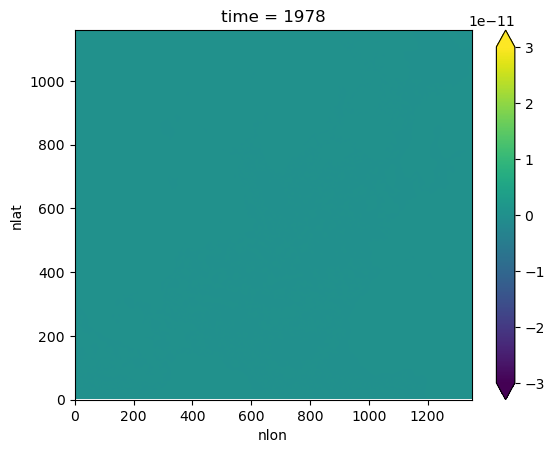

In [41]:
susv_wvel.isel(time=10).plot(vmin=-3e-11,vmax=3e-11)

### Get approximate cross-sectional area for inflow & outflow

In [36]:
tmp = ((hr_gom - hr_gom.shift(nlat=1))==1) & (hr_lon>=-87) & (hr_lon<=-84.6)

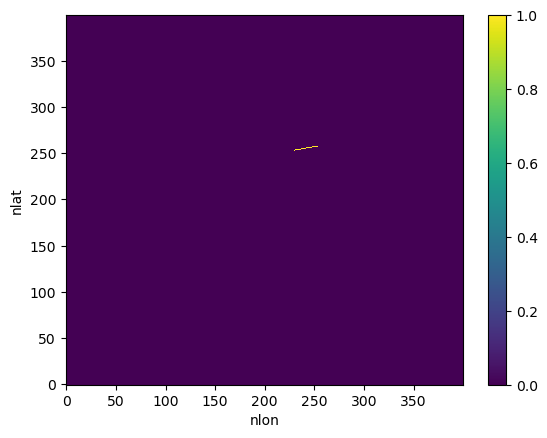

In [37]:
tmp.isel(nlon=slice(0,400)).isel(nlat=slice(0,400)).plot()

In [38]:
inflow_depth = xr.where(tmp,hr_ht,np.nan).mean(['nlon','nlat'])
inflow_ann = xr.where(tmp,svann,np.nan).sum(['nlon','nlat']).load()

In [39]:
tmp = ((hr_gom - hr_gom.roll(nlon=-1,roll_coords=False))==1) & (hr_lat>=23.2) & (hr_lat<=25.1)

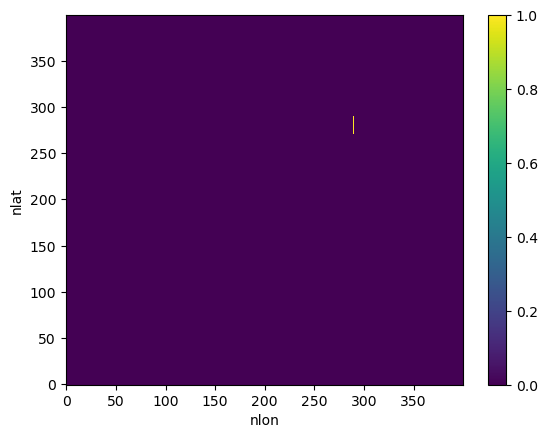

In [40]:
tmp.isel(nlon=slice(0,400)).isel(nlat=slice(0,400)).plot()

In [41]:
outflow_depth = xr.where(tmp,hr_ht,np.nan).mean(['nlon','nlat'])
outflow_ann = xr.where(tmp,suann,np.nan).sum(['nlon','nlat']).load()

## Some plots to explore the relation between BSF/SSH in the GoM

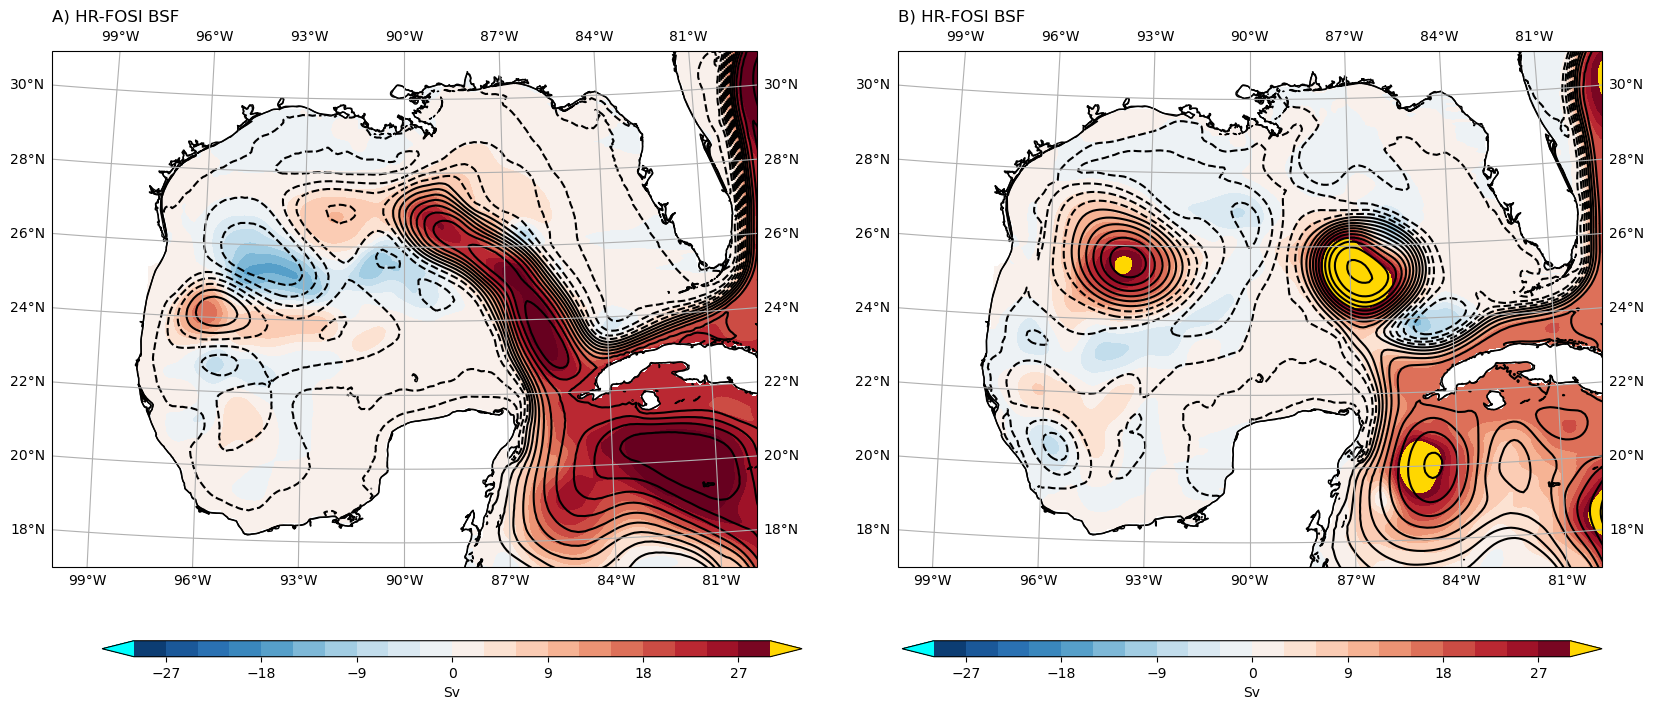

In [27]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)
overclr = 'gold'
underclr = 'cyan'
lineclr = 'yellow'
lineclr2 = 'orange'

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1, projection=proj2)
ax2 = fig.add_subplot(1, 2, 2, projection=proj2)

bsflevs = np.arange(0,21,1)*3. - 30
sshlevs = np.arange(0,21,1)*5. - 50

cntr1 = ax1.contourf(hr_lon, hr_lat, ds_bsf.BSF.isel(time=100), levels=bsflevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
cntr1.cmap.set_over(overclr)
cntr1.cmap.set_under(underclr)
cntr1a = ax1.contour(hr_lon, hr_lat, ds_ssh.SSH.isel(time=100), levels=sshlevs, colors='k', transform=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) HR-FOSI BSF',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,-80, 17, 31]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

cntr2 = ax2.contourf(hr_lon, hr_lat, ds_bsf.BSF.isel(time=300), levels=bsflevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
cntr2.cmap.set_over(overclr)
cntr2.cmap.set_under(underclr)
cntr2a = ax2.contour(hr_lon, hr_lat, ds_ssh.SSH.isel(time=300), levels=sshlevs, colors='k', transform=ccrs.PlateCarree())
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI BSF',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,-80, 17, 31]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='Sv')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='Sv')

This plots shows monthly-mean snapshots of BSF (color shade) and SSH (contour lines) from HR-FOSI cycle 5.

### Pointwise BSF/SSH Correlation

In [15]:
import xskillscore as xs

In [19]:
# Get 1968-2018 monthly data
tmp1 = ds_bsf.BSF.chunk({'nlat':50,'time':-1}).isel(time=slice(120,None)).astype('float32')
tmp2 = ds_ssh.SSH.drop(['TLAT','TLONG']).chunk({'nlat':50,'time':-1}).isel(time=slice(120,None))
corr = xs.pearson_r(tmp1,tmp2,dim='time')
corr = dask.optimize(corr)[0]

In [20]:
%%time
corr_mon = corr.load()

CPU times: user 29.6 s, sys: 2.35 s, total: 32 s
Wall time: 2min 18s


In [20]:
tmp1ann = tmp1.groupby('time.year').mean('time').rename({'year':'time'}).chunk({'time':-1})
tmp2ann = tmp2.groupby('time.year').mean('time').rename({'year':'time'}).chunk({'time':-1})
corrann = xs.pearson_r(tmp1ann,tmp2ann,dim='time')
corrann = dask.optimize(corrann)[0]

In [22]:
%%time
corr_ann = corrann.load()

CPU times: user 28.4 s, sys: 2.22 s, total: 30.7 s
Wall time: 1min 55s


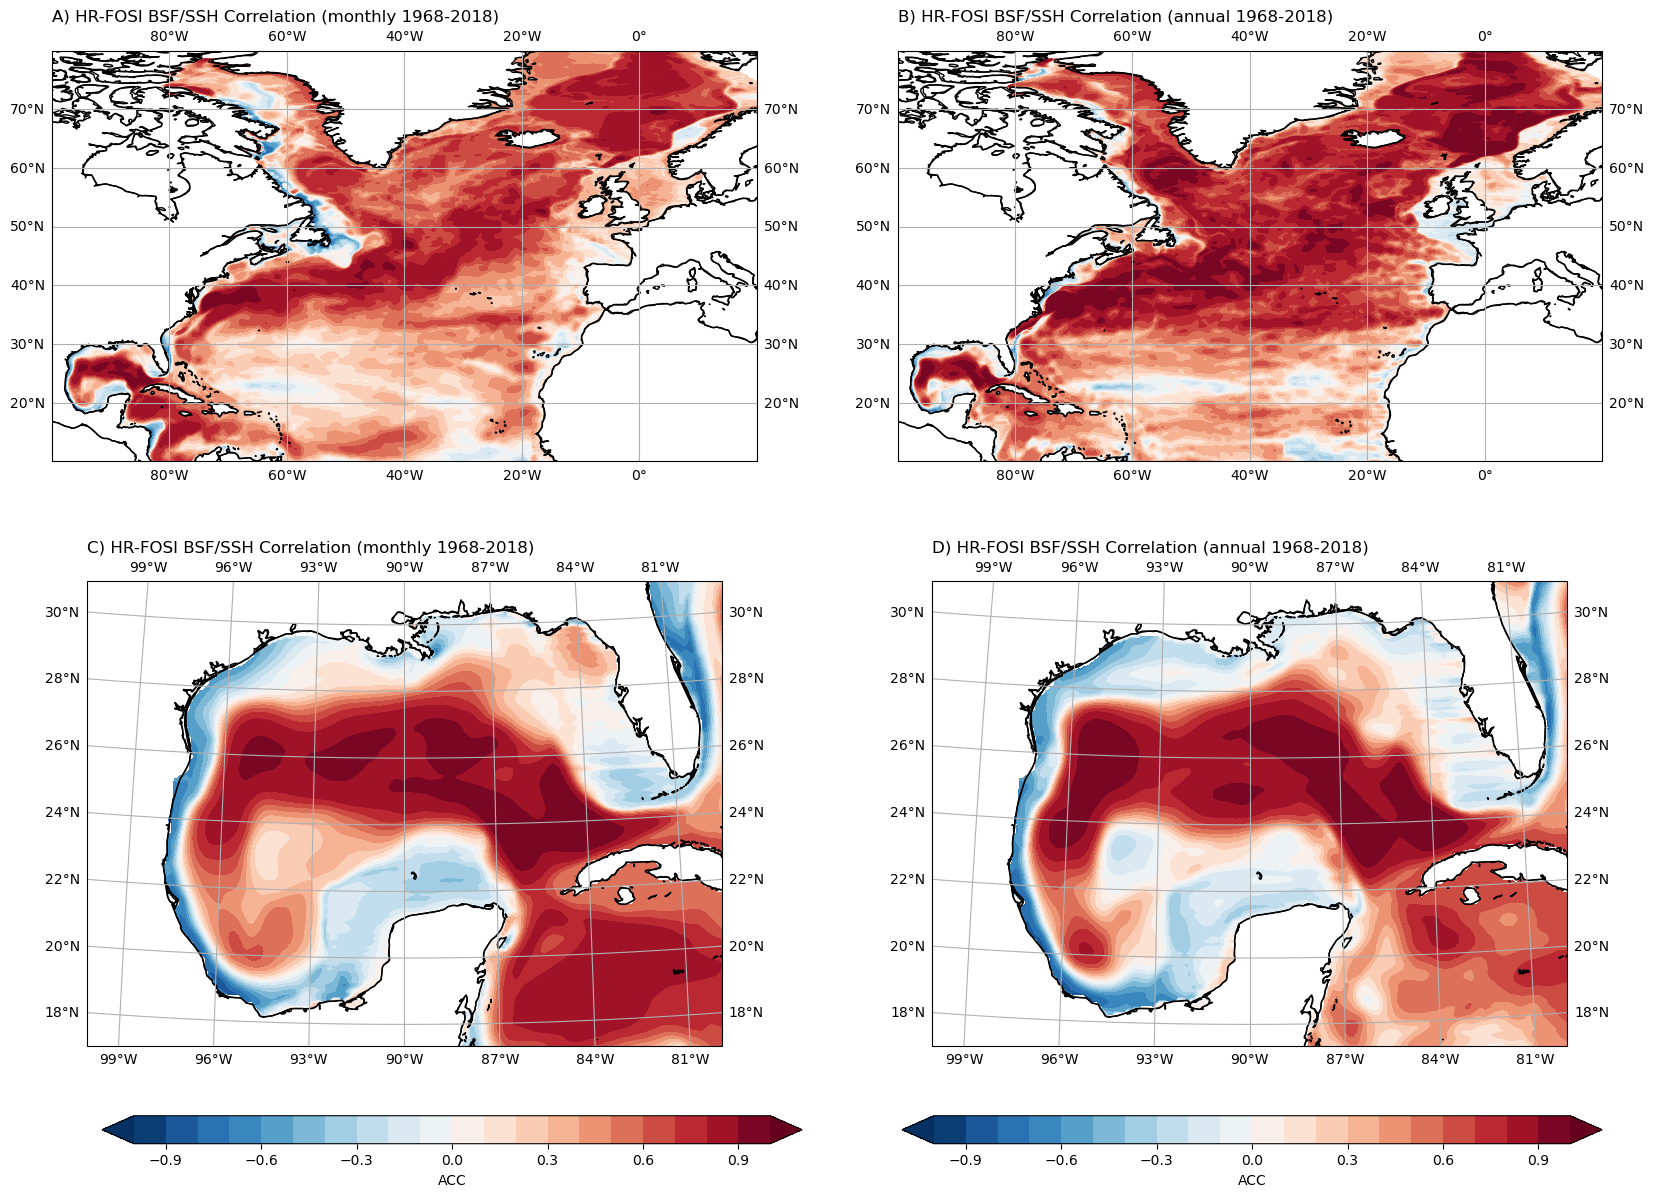

In [33]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(2, 2, 1, projection=proj1)
ax2 = fig.add_subplot(2, 2, 2, projection=proj1)
ax3 = fig.add_subplot(2, 2, 3, projection=proj2)
ax4 = fig.add_subplot(2, 2, 4, projection=proj2)

rlevs = np.arange(0,21,1)*0.1 - 1

cntr1 = ax1.contourf(hr_lon, hr_lat, corr_mon, levels=rlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) HR-FOSI BSF/SSH Correlation (monthly 1968-2018)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,20, 10, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

cntr2 = ax2.contourf(hr_lon, hr_lat, corr_ann, levels=rlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI BSF/SSH Correlation (annual 1968-2018)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,20, 10, 80]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

cntr3 = ax3.contourf(hr_lon, hr_lat, corr_mon, levels=rlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax3.coastlines(resolution='50m')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.set_title('C) HR-FOSI BSF/SSH Correlation (monthly 1968-2018)',fontsize=fontsize, loc='left')
ax3.coastlines()
extent = [-100,-80, 17, 31]
ax3.set_extent(extent,crs=ccrs.PlateCarree())

cntr4 = ax4.contourf(hr_lon, hr_lat, corr_ann, levels=rlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax4.coastlines(resolution='50m')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax4.set_title('D) HR-FOSI BSF/SSH Correlation (annual 1968-2018)',fontsize=fontsize, loc='left')
ax4.coastlines()
extent = [-100,-80, 17, 31]
ax4.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='ACC')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='ACC')

Pointwise correlation (1968-2018) of BSF with SSH using monthly data (left) and annual data (right).

### Correlation between inflow/outflow of GoM and interior SSH

In [42]:
# Use xoak to select specific [lat,lon] nearest values from CAM unstructured grid:
import xoak
def kdtree_sel_POPT(ds, lats, lons):
    if not ds.xoak.index:
        ds.xoak.set_index(("TLAT", "TLONG"), "scipy_kdtree")
    return ds.xoak.sel(TLAT=xr.Variable("ncol", lats1), TLONG=xr.Variable("ncol", lons1))

def kdtree_sel_POPU(ds, lats, lons):
    if not ds.xoak.index:
        ds.xoak.set_index(("ULAT", "ULONG"), "scipy_kdtree")
    return ds.xoak.sel(ULAT=xr.Variable("ncol", lats1), ULONG=xr.Variable("ncol", lons1))

In [45]:
%%time
sshann = ds_ssh.SSH.drop(['ULAT','ULONG']).isel(time=slice(120,None))
sshann = sshann.groupby('time.year').mean('time').rename({'year':'time'})
#sshann = sshann.persist()
sshann['TLONG'] = hr_lon
sshann['TLAT'] = hr_lat

CPU times: user 384 ms, sys: 7.45 ms, total: 391 ms
Wall time: 427 ms


In [45]:
%%time
bsfann = ds_bsf.BSF.chunk({'nlat':50,'time':-1}).isel(time=slice(120,None))
bsfann = bsfann.groupby('time.year').mean('time').rename({'year':'time'}).chunk({'time':-1})
bsfann = bsfann.persist()

CPU times: user 709 ms, sys: 29.9 ms, total: 739 ms
Wall time: 780 ms


In [40]:
annssh2018 = sshann.sel(time=2018).load()
annssh2005 = sshann.sel(time=2005).load()
annsshdiff = annssh2018 - annssh2005

In [41]:
%%time
lons1 = [-87,-84.6,-81,-81]
lats1 = [21.6,22,23.2,25.1]
ssh1 = kdtree_sel_POPT(annssh2005,lats1,lons1).load().squeeze()

CPU times: user 658 ms, sys: 16 ms, total: 674 ms
Wall time: 895 ms


In [81]:
ssh1

<xarray.DataArray 'SSH' (ncol: 4)>
array([-21.556948,  25.101257,  20.827188, -24.173468], dtype=float32)
Coordinates:
    TLONG    (ncol) float64 -87.05 -84.65 -81.05 -80.95
    TLAT     (ncol) float64 21.62 21.99 23.19 25.11
    time     int64 2005
Dimensions without coordinates: ncol
Attributes:
    long_name:     Sea Surface Height
    units:         centimeter
    grid_loc:      2110
    cell_methods:  time: mean

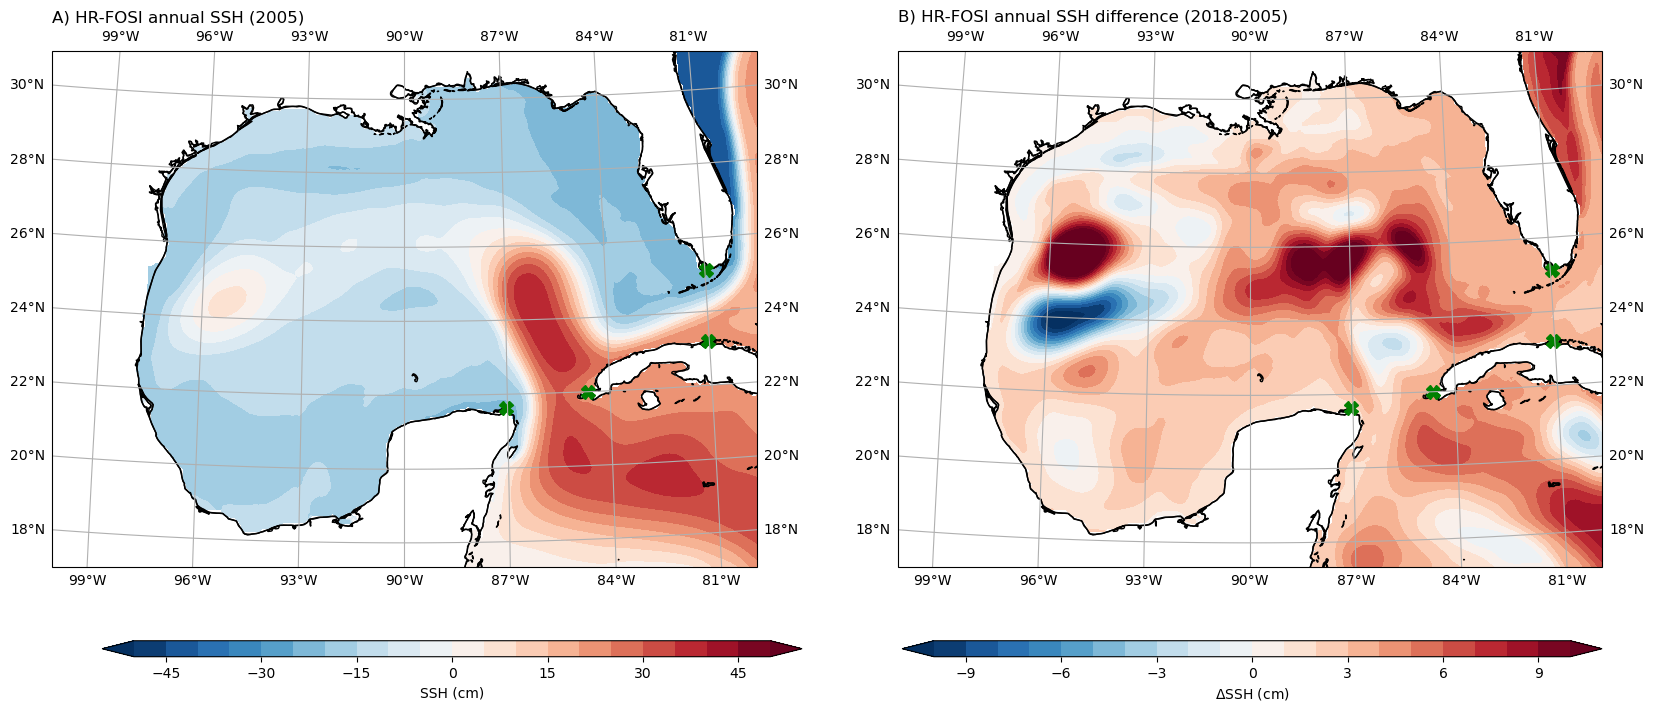

In [82]:
central_lon, central_lat = -90, 25
fontsize=12

sshlevs = np.arange(0,21,1)*5. - 50
sshdifflevs = np.arange(0,21,1)*1 - 10

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1, projection=proj2)
ax2 = fig.add_subplot(1, 2, 2, projection=proj2)

rlevs = np.arange(0,21,1)*0.1 - 1

cntr1 = ax1.contourf(hr_lon, hr_lat, annssh2005, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) HR-FOSI annual SSH (2005)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,-80, 17, 31]
ax1.set_extent(extent,crs=ccrs.PlateCarree())
ax1.plot(ssh1.TLONG, ssh1.TLAT,'X',markersize=10,c='g',transform=ccrs.PlateCarree())

cntr2 = ax2.contourf(hr_lon, hr_lat, annsshdiff, levels=sshdifflevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI annual SSH difference (2018-2005)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,-80, 17, 31]
ax2.set_extent(extent,crs=ccrs.PlateCarree())
ax2.plot(ssh1.TLONG, ssh1.TLAT,'X',markersize=10,c='g',transform=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='SSH (cm)')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label=r'$\Delta$SSH (cm)')

### Compute Approximate barotropic geostrophic inflow and outflow

In [46]:
from math import radians, degrees, sin, cos, asin, acos, sqrt
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

In [75]:
lats1,lons1

([21.6, 22, 23.2, 25.1], [-87, -84.6, -81, -81])

In [76]:
great_circle(lons1[0], lats1[0], lons1[1], lats1[1])

251.74013144036851

In [43]:
import math
omega = 7.29e-5     # sec^-1
deg2rad = math.pi/180.
rho0 = 1029. # kg/m^3
g = 9.81 # m/s^2
hr_fcor = 2*omega*np.sin(hr_lat*deg2rad)
fcor_ABDC = kdtree_sel_POPT(hr_fcor,lats1,lons1).load().squeeze()

In [46]:
%%time
ssh1 = kdtree_sel_POPT(sshann,lats1,lons1).load().squeeze()

CPU times: user 15.1 s, sys: 1.14 s, total: 16.2 s
Wall time: 1min 3s


In [47]:
ssh1_anom = ssh1 - ssh1.mean('time')

In [48]:
sshA = ssh1_anom.isel(ncol=0)
sshB = ssh1_anom.isel(ncol=1)
sshC = ssh1_anom.isel(ncol=3)
sshD = ssh1_anom.isel(ncol=2)

ssh_BminusA = sshB - sshA
ssh_DminusC = sshD - sshC

#dx_inflow = great_circle(lons1[0], lats1[0], lons1[1], lats1[1])*100.
ssh_inflow = ((sshB/100.)*(g/fcor_ABDC.isel(ncol=1)) - (sshA/100.)*(g/fcor_ABDC.isel(ncol=0)))*inflow_depth/1.e6 # Sv
ssh_inflow.attrs['units']='Sv'
ssh_outflow = ((sshD/100.)*(g/fcor_ABDC.isel(ncol=2)) - (sshC/100.)*(g/fcor_ABDC.isel(ncol=3)))*outflow_depth/1.e6 # Sv
ssh_outflow.attrs['units']='Sv'

ssh_conv = ssh_inflow - ssh_outflow
ssh_conv.attrs['units']='Sv'

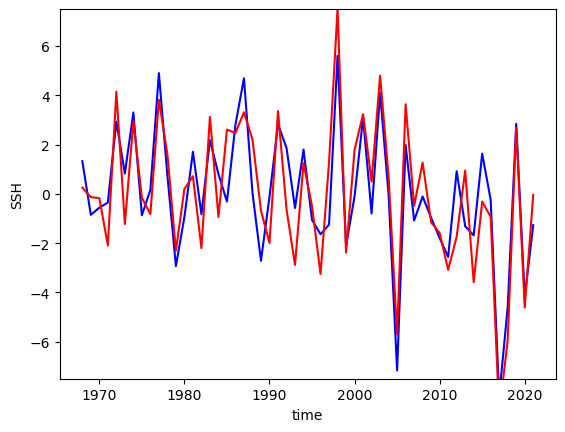

In [57]:
ssh_BminusA.plot(c='b',ylim=[-7.5,7.5],add_legend=True)
ssh_DminusC.plot(c='r')

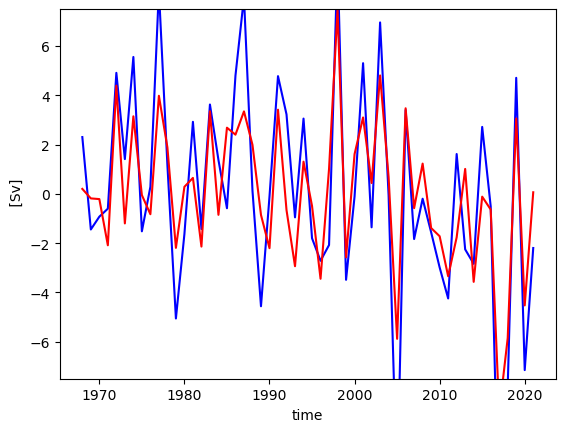

In [52]:
ssh_inflow.plot(c='b',ylim=[-7.5,7.5])
ssh_outflow.plot(c='r')

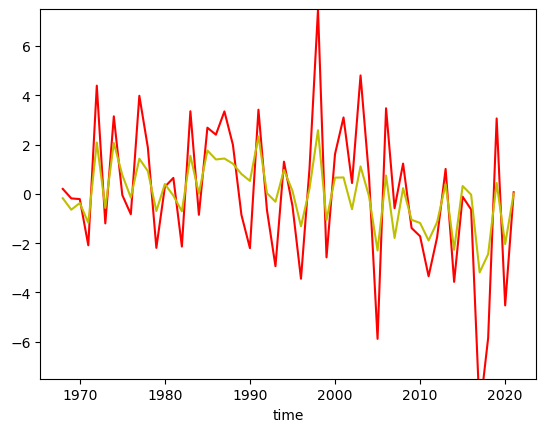

In [81]:
ssh_outflow.plot(c='r',ylim=[-7.5,7.5],label='SSH outflow',add_legend=True)
outflow_anom = outflow_ann - outflow_ann.mean('time')
outflow_anom.plot(c='y',label='True outflow')

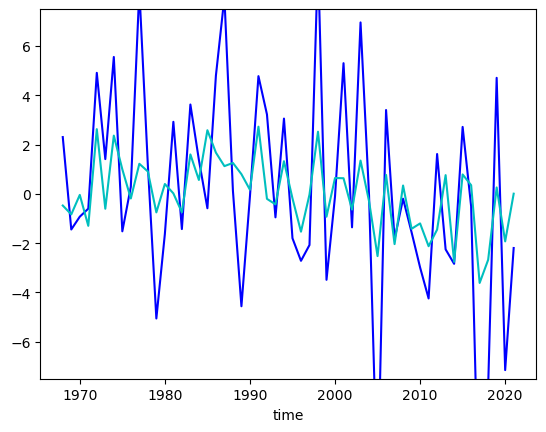

In [87]:
ssh_inflow.plot(c='b',ylim=[-7.5,7.5],label='SSH inflow',add_legend=True)
inflow_anom = inflow_ann - inflow_ann.mean('time')
inflow_anom.plot(c='c',label='True inflow')

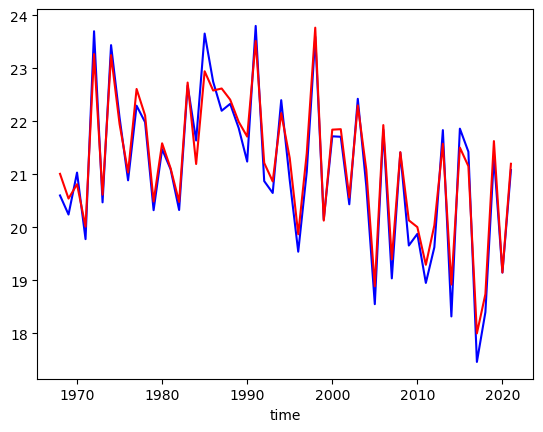

In [92]:
inflow_ann.plot(c='b')
outflow_ann.plot(c='r')

In [49]:
vel_conv = inflow_ann - outflow_ann
vel_conv.attrs['units']='Sv'
vel_conv_anom = vel_conv -vel_conv.mean('time')

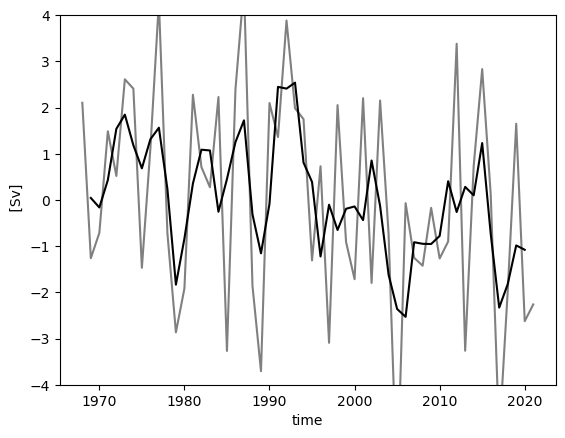

In [62]:
ssh_conv.plot(c='grey',ylim=[-4,4])
ssh_conv.rolling(time=3, center=True).mean().plot(c='k')

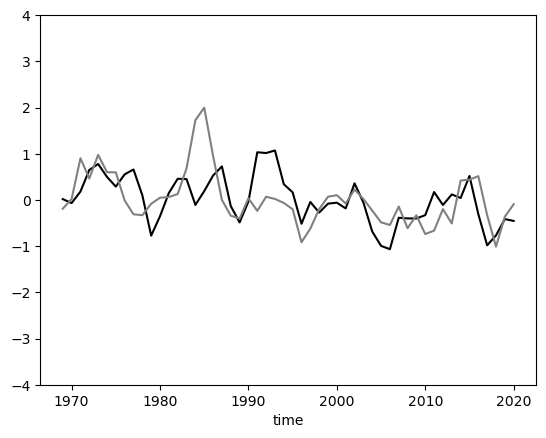

In [50]:
ssh_conv_norm = ssh_conv/ssh_conv.std('time')
vel_conv_norm = vel_conv_anom/vel_conv_anom.std('time')
ssh_conv_norm.rolling(time=3, center=True).mean().plot(c='k',ylim=[-4,4])
vel_conv_norm.rolling(time=3, center=True).mean().plot(c='grey',ylim=[-4,4])

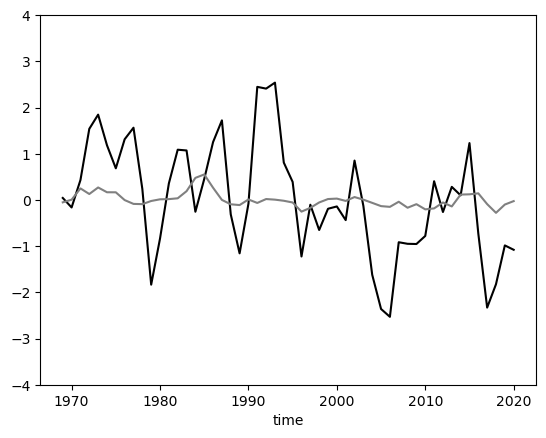

In [94]:
ssh_conv.rolling(time=3, center=True).mean().plot(c='k',ylim=[-4,4])
vel_conv_anom.rolling(time=3, center=True).mean().plot(c='grey',ylim=[-4,4])

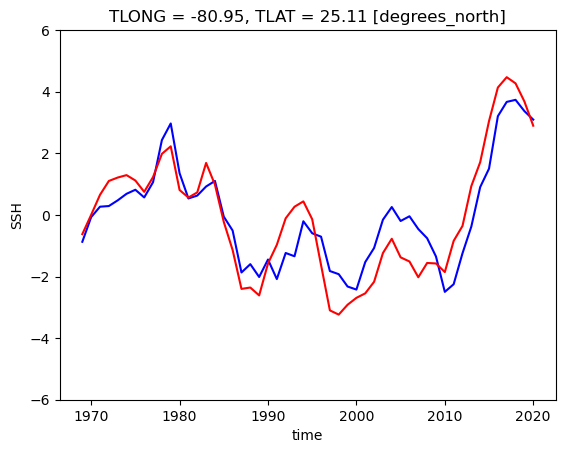

In [30]:
ssh1_anom.isel(ncol=0).rolling(time=3, center=True).mean().plot(c='b',ylim=[-6,6])
ssh1_anom.isel(ncol=3).rolling(time=3, center=True).mean().plot(c='r')

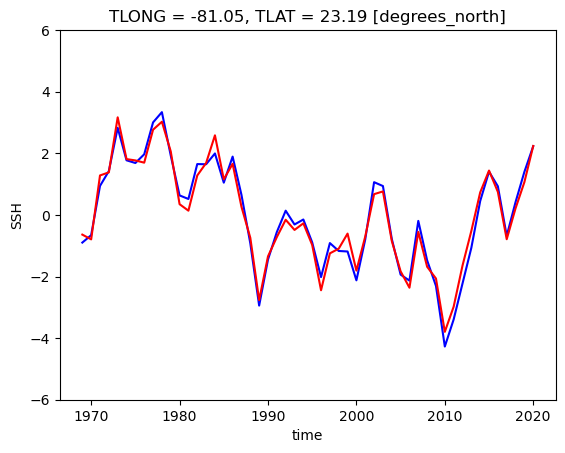

In [31]:
ssh1_anom.isel(ncol=1).rolling(time=3, center=True).mean().plot(c='b',ylim=[-6,6])
ssh1_anom.isel(ncol=2).rolling(time=3, center=True).mean().plot(c='r')

In [38]:
coastal_diff = ssh1_anom.isel(ncol=3).rolling(time=3, center=True).mean() - ssh1_anom.isel(ncol=0).rolling(time=3, center=True).mean()
interior_diff = ssh1_anom.isel(ncol=1).rolling(time=3, center=True).mean() - ssh1_anom.isel(ncol=2).rolling(time=3, center=True).mean()

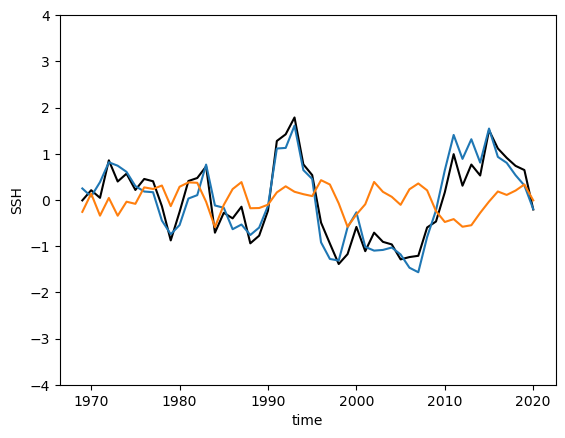

In [40]:
ssh_delta.rolling(time=3, center=True).mean().plot(c='k',ylim=[-4,4], label='inflow-outflow')
coastal_diff.plot()
interior_diff.plot()

In [37]:
def POP_regional_areawgt(da,tarea,lonlat):
    tlat = da.TLAT
    tlon = xr.where(da.TLONG>180.,da.TLONG-360.,da.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [59]:
reglonlat = [-99.,-81.,22.,30.]

In [60]:
POP_regarea = POP_regional_areawgt(ds_t13,hr_tarea,reglonlat).load()

In [51]:
POP_GOMarea = xr.where(hr_gom,hr_tarea,0)

In [52]:
%%time
hr_GOMssh = sshann.weighted(POP_GOMarea).mean(("nlon", "nlat")).load()

CPU times: user 18.1 s, sys: 1.32 s, total: 19.4 s
Wall time: 1min 10s


In [55]:
hr_GOMssh_anom = hr_GOMssh - hr_GOMssh.mean('time')

In [53]:
GOM_conv = susv_conv.weighted(POP_GOMarea).sum(("nlon", "nlat")).load()

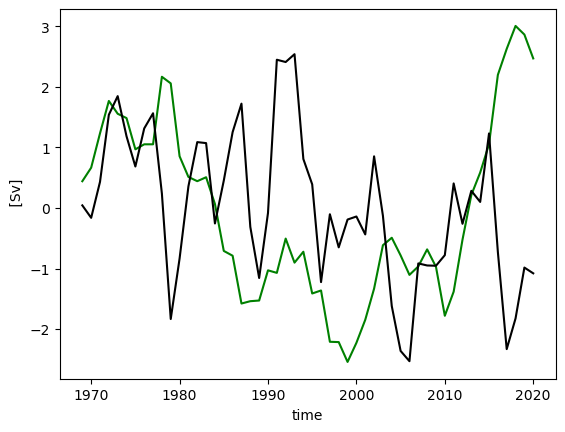

In [66]:
hr_GOMssh_anom.rolling(time=3, center=True).mean().plot(c='g')
ssh_conv.rolling(time=3, center=True).mean().plot(c='k')

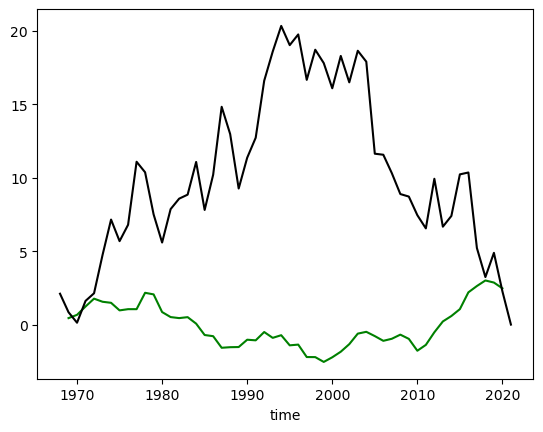

In [67]:
hr_GOMssh_anom.rolling(time=3, center=True).mean().plot(c='g')
ssh_conv.cumsum('time').plot(c='k')

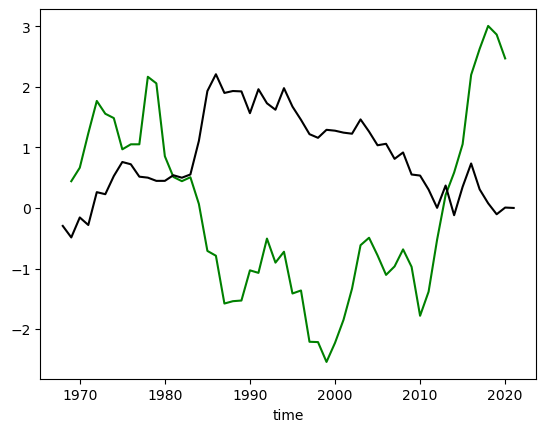

In [95]:
hr_GOMssh_anom.rolling(time=3, center=True).mean().plot(c='g')
vel_conv_anom.cumsum('time').plot(c='k')

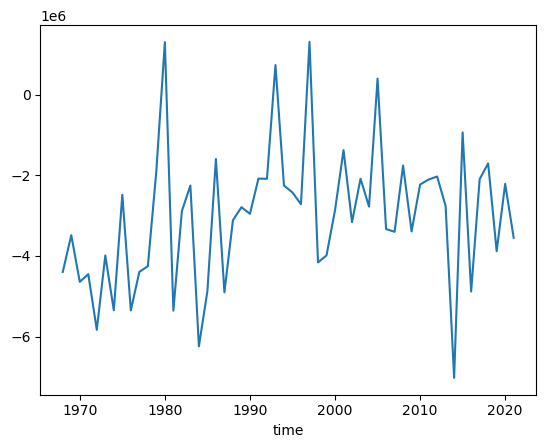

In [57]:
GOM_conv.plot()

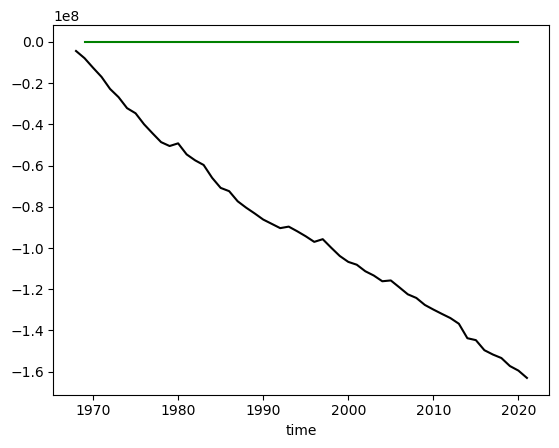

In [56]:
hr_GOMssh_anom.rolling(time=3, center=True).mean().plot(c='g')
GOM_conv.cumsum('time').plot(c='k')

## Interannual Variability: Acceleration of sea level rise in GoM and SEUS

#### Altimetry Data

In [26]:
datadir = '/glade/work/clittle/altimetry/MEASURES/monthly/'
alt=xr.open_mfdataset(datadir+'monthly_*.nc')
alt=alt*100        # convert to cm
alt=alt.rename({'Time': 'time'})
nt = alt.dims['time']
years = alt.time.dt.year
mons = alt.time.dt.month
alt['time'] = [cftime.DatetimeNoLeap(years[i], mons[i], 15) for i in range(nt)]
altmon = alt.SLA

In [27]:
alt_montime = altmon.time.dt.year + (altmon.time.dt.month-0.5)/12.

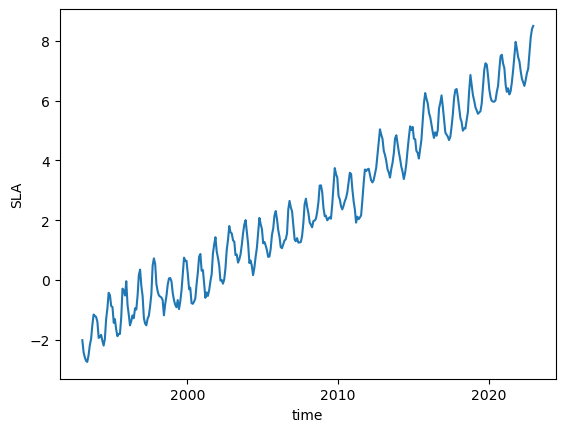

In [28]:
# remove global mean signal for comparison with FOSI
weights = np.cos(np.deg2rad(altmon.Latitude))
altmon_global = altmon.weighted(weights).mean('Latitude').mean('Longitude')
altmon_global.plot()

In [29]:
altmon_raw = altmon

In [30]:
altmon = altmon - altmon_global

In [31]:
altann = altmon.groupby('time.year').mean('time').rename({'year':'time'}).load()

In [47]:
altann_raw = altmon_raw.groupby('time.year').mean('time').rename({'year':'time'})

### 1993-2018 Std. Dev.

In [43]:
alt_sd = altann.std('time').load()

In [44]:
alt_raw_sd = altann_raw.std('time').load()

In [54]:
hr_ssh_sd = sshann.sel(time=slice(1993,2018)).std('time').load()

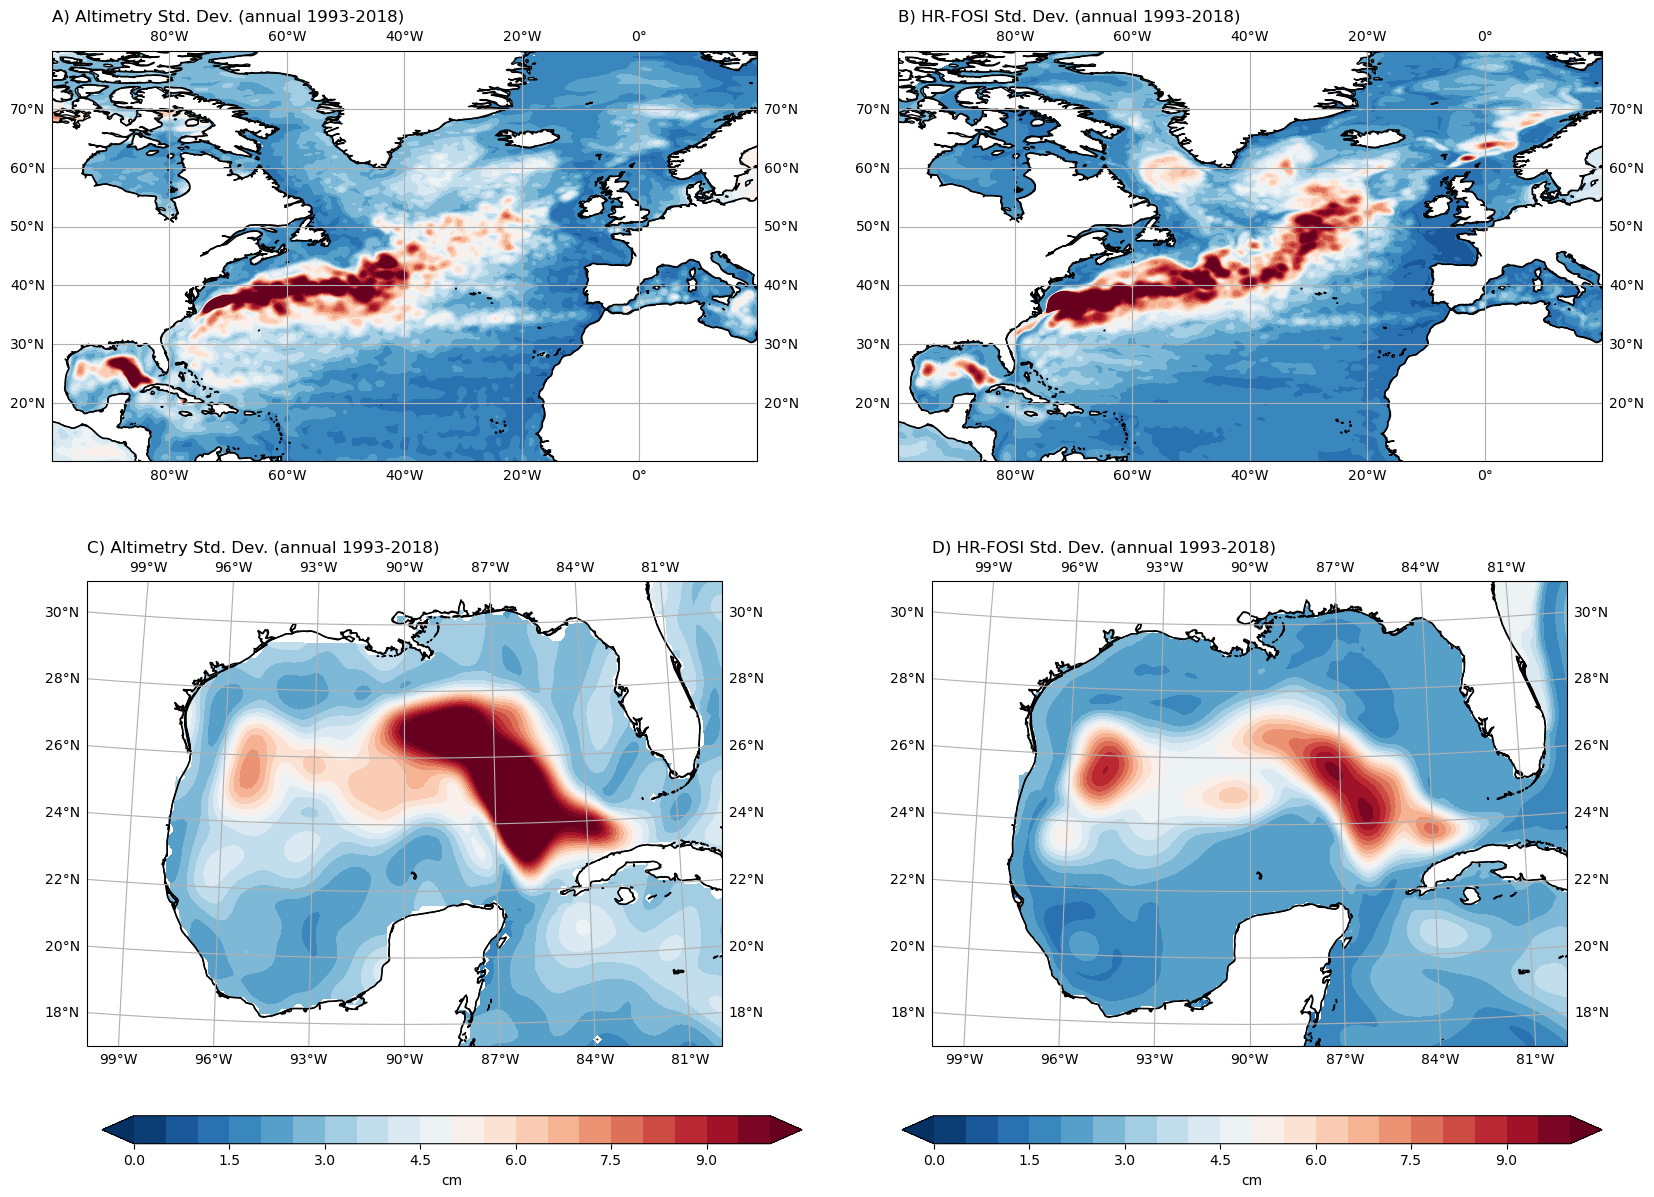

In [55]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(2, 2, 1, projection=proj1)
ax2 = fig.add_subplot(2, 2, 2, projection=proj1)
ax3 = fig.add_subplot(2, 2, 3, projection=proj2)
ax4 = fig.add_subplot(2, 2, 4, projection=proj2)

sshlevs = np.arange(0,21,1)*0.5 

cntr1 = ax1.contourf(alt_sd.Longitude, alt_sd.Latitude, alt_sd, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) Altimetry Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,20, 10, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

cntr2 = ax2.contourf(hr_lon, hr_lat, hr_ssh_sd, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,20, 10, 80]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

cntr3 = ax3.contourf(alt_sd.Longitude, alt_sd.Latitude, alt_sd, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax3.coastlines(resolution='50m')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.set_title('C) Altimetry Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax3.coastlines()
extent = [-100,-80, 17, 31]
ax3.set_extent(extent,crs=ccrs.PlateCarree())

cntr4 = ax4.contourf(hr_lon, hr_lat, hr_ssh_sd, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax4.coastlines(resolution='50m')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax4.set_title('D) HR-FOSI Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax4.coastlines()
extent = [-100,-80, 17, 31]
ax4.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='cm')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='cm')

Interannual Std. Dev. (1993-2018) of DSL from altimetry (left) and HR-FOSI (right).

### 2000-2015 Trend

In [32]:
import xskillscore as xs

In [33]:
%%time
tmp = altann.sel(time=slice(2000,2015))
alt_trend = xs.linslope(tmp.time,tmp,dim='time')

CPU times: user 366 ms, sys: 182 ms, total: 548 ms
Wall time: 591 ms


In [44]:
%%time
tmp = sshann.sel(time=slice(2000,2015))
hr_trend = xs.linslope(tmp.time,tmp,dim='time').load()

/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 191.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 3.68 s, sys: 576 ms, total: 4.26 s
Wall time: 15.8 s


In [36]:
# Get 1993-2018 monthly data
m1 = (1993-1958)*12
m2 = (2018-1958)*12 + 12
tmp2 = ds_ssh.SSH.drop(['TLAT','TLONG']).chunk({'nlat':50,'time':-1}).isel(time=slice(m1,m2))
hrfosi_yrfrc = (tmp2.time.dt.year + (tmp2.time.dt.month-0.5)/12.) - 245 + 1958
hr_trend_mon = xs.linslope(hrfosi_yrfrc,tmp2,dim='time').load()

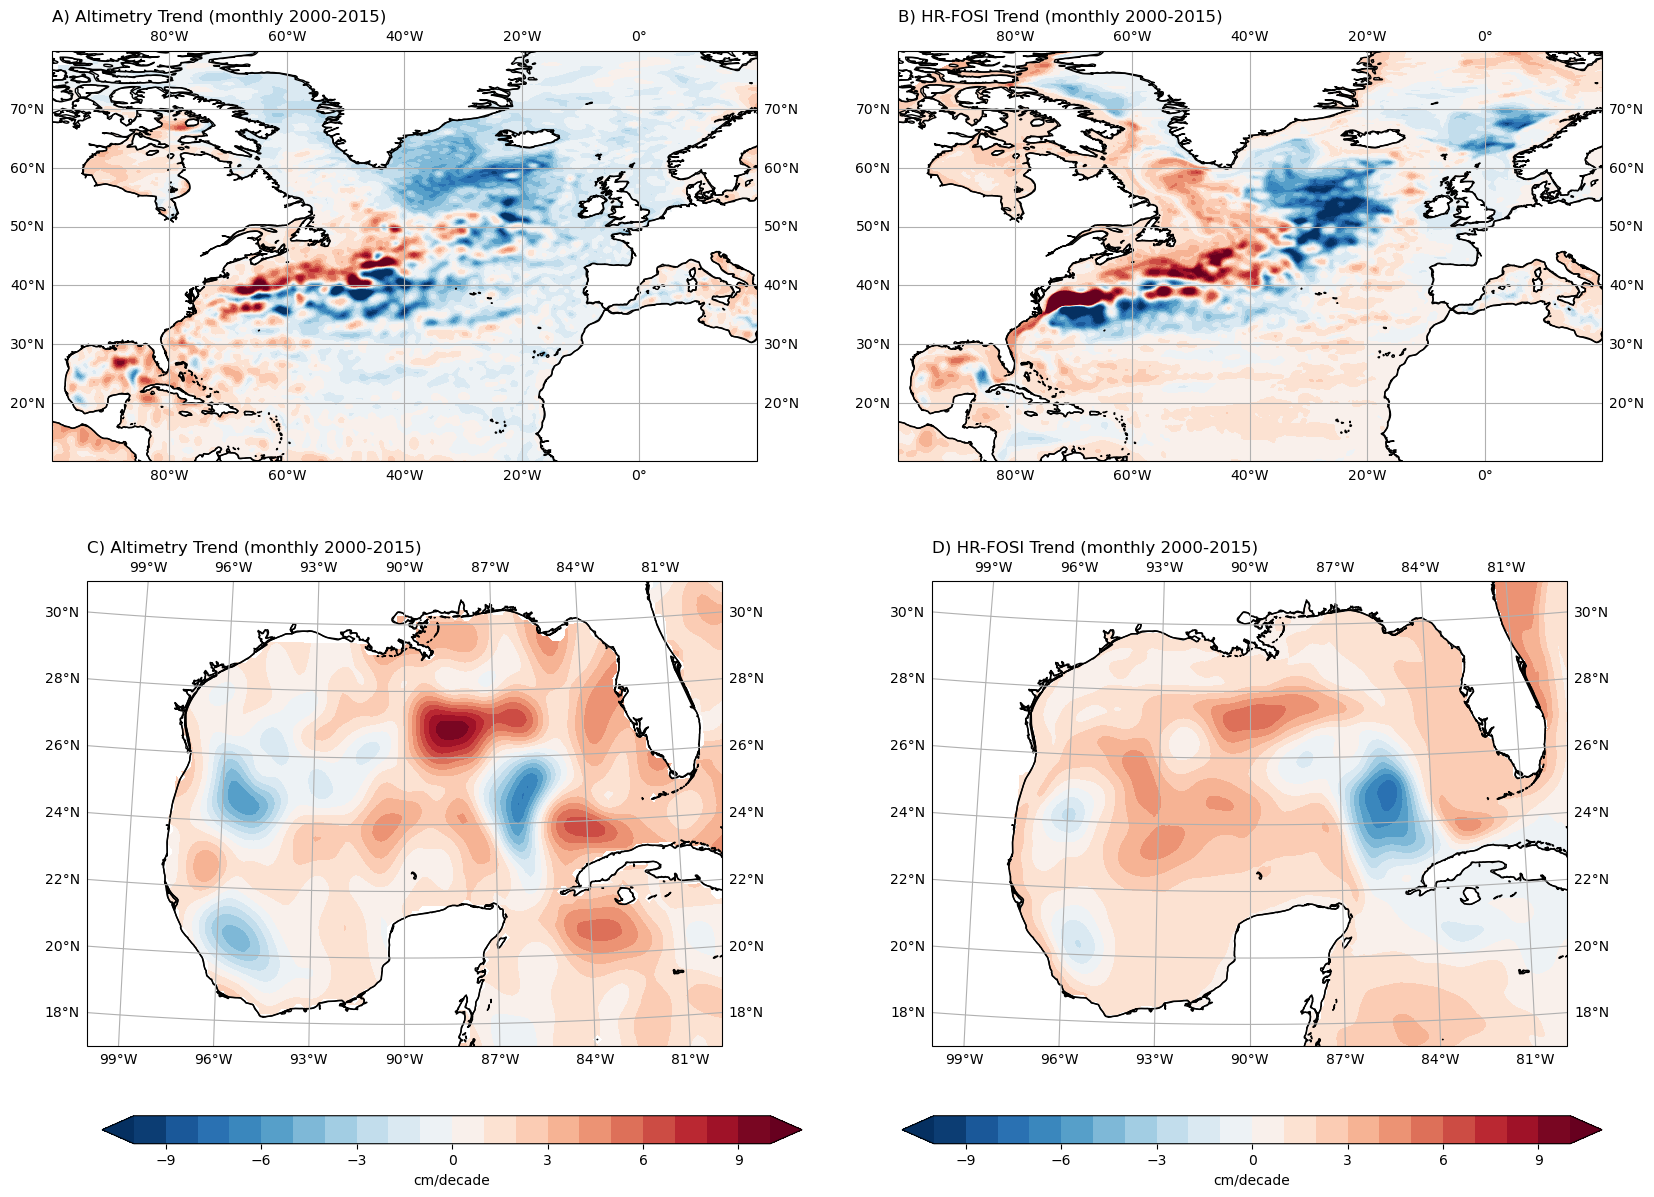

In [59]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(2, 2, 1, projection=proj1)
ax2 = fig.add_subplot(2, 2, 2, projection=proj1)
ax3 = fig.add_subplot(2, 2, 3, projection=proj2)
ax4 = fig.add_subplot(2, 2, 4, projection=proj2)

sshlevs = np.arange(0,21,1)*1 - 10

cntr1 = ax1.contourf(alt_trend.Longitude, alt_trend.Latitude, alt_trend*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) Altimetry Trend (monthly 2000-2015)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,20, 10, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

cntr2 = ax2.contourf(hr_lon, hr_lat, hr_trend*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI Trend (monthly 2000-2015)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,20, 10, 80]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

cntr3 = ax3.contourf(alt_trend.Longitude, alt_trend.Latitude, alt_trend*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax3.coastlines(resolution='50m')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.set_title('C) Altimetry Trend (monthly 2000-2015)',fontsize=fontsize, loc='left')
ax3.coastlines()
extent = [-100,-80, 17, 31]
ax3.set_extent(extent,crs=ccrs.PlateCarree())

cntr4 = ax4.contourf(hr_lon, hr_lat, hr_trend*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax4.coastlines(resolution='50m')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax4.set_title('D) HR-FOSI Trend (monthly 2000-2015)',fontsize=fontsize, loc='left')
ax4.coastlines()
extent = [-100,-80, 17, 31]
ax4.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='cm/decade')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='cm/decade')

Linear trend (2000-2015) of DSL from altimetry (left) and HR-FOSI (right).

#### How much does trend contribute to 1993-2018 variability?

In [39]:
def trend_linear(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    return fit

In [44]:
%%time
altann_trend_sd = trend_linear(altann,'time').std('time').load()
alt_sd_ratio = altann_trend_sd/alt_sd

CPU times: user 9.94 s, sys: 361 ms, total: 10.3 s
Wall time: 1min 14s


In [47]:
%%time
hr_ssh_trend_sd = trend_linear(hr_sshann.sel(time=slice(1993,2018)),'time').std('time').load()

CPU times: user 18.3 s, sys: 525 ms, total: 18.8 s
Wall time: 1min 38s


In [48]:
hr_sd_ratio = hr_ssh_trend_sd/hr_ssh_sd

In [51]:
np.arange(0,21,1)*0.05 

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

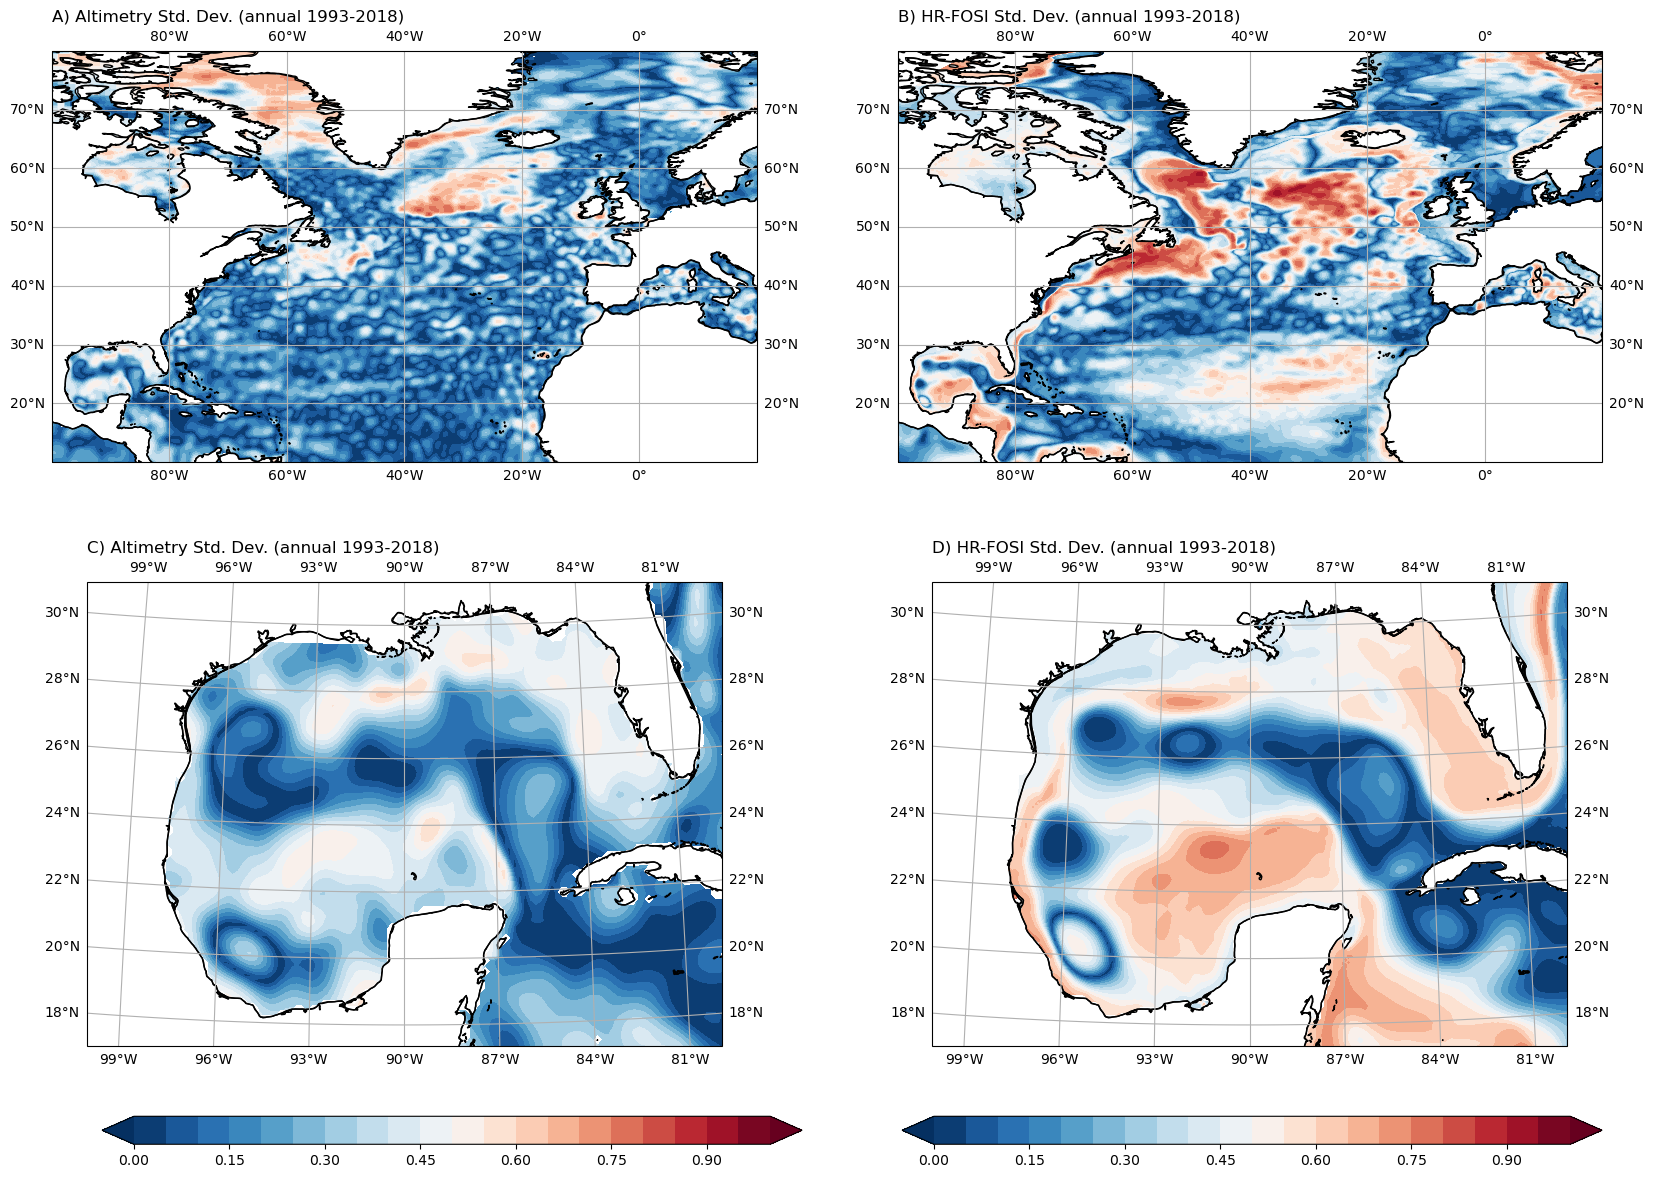

In [53]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(2, 2, 1, projection=proj1)
ax2 = fig.add_subplot(2, 2, 2, projection=proj1)
ax3 = fig.add_subplot(2, 2, 3, projection=proj2)
ax4 = fig.add_subplot(2, 2, 4, projection=proj2)

sshlevs = np.arange(0,21,1)*0.05

cntr1 = ax1.contourf(alt_sd_ratio.Longitude, alt_sd_ratio.Latitude, alt_sd_ratio, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) Altimetry Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,20, 10, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

cntr2 = ax2.contourf(hr_lon, hr_lat, hr_sd_ratio, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,20, 10, 80]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

cntr3 = ax3.contourf(alt_sd_ratio.Longitude, alt_sd_ratio.Latitude, alt_sd_ratio, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax3.coastlines(resolution='50m')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.set_title('C) Altimetry Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax3.coastlines()
extent = [-100,-80, 17, 31]
ax3.set_extent(extent,crs=ccrs.PlateCarree())

cntr4 = ax4.contourf(hr_lon, hr_lat, hr_sd_ratio, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax4.coastlines(resolution='50m')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax4.set_title('D) HR-FOSI Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax4.coastlines()
extent = [-100,-80, 17, 31]
ax4.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='')

Fraction of interannual variability (1993-2018) explained by linear trend.

### Eastern GoM Variability

In [17]:
reglonlat = [-84.,-81.,25.,28.]

In [18]:
def add_box(ax,lonlat):
    x0 = lonlat[0]; x1 = lonlat[1]; y0 = lonlat[2]; y1 = lonlat[3]
    if ((x0>0) and (x1<0)):
        ax.plot(np.linspace(x0,x0,20), np.linspace(y0,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x1,x1,20), np.linspace(y0,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,180,20), np.linspace(y0,y0,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(-180,x1,20), np.linspace(y0,y0,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,180,20), np.linspace(y1,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(-180,x1,20), np.linspace(y1,y1,20), color='k',transform=ccrs.PlateCarree())
    else:
        ax.plot(np.linspace(x0,x0,20), np.linspace(y0,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x1,x1,20), np.linspace(y0,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,x1,20), np.linspace(y0,y0,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,x1,20), np.linspace(y1,y1,20), color='k',transform=ccrs.PlateCarree())

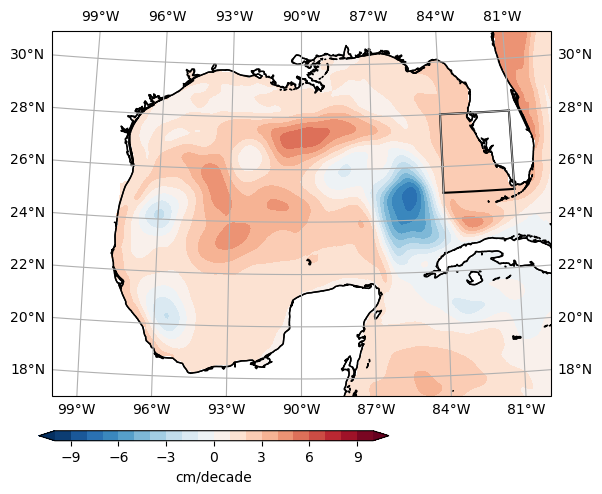

In [47]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1, projection=proj2)


sshlevs = np.arange(0,21,1)*1 - 10

cntr1 = ax1.contourf(hr_lon, hr_lat, hr_trend*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,-80, 17, 31]
ax1.set_extent(extent,crs=ccrs.PlateCarree())
add_box(ax1,reglonlat)


fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.25, 0.06, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='cm/decade')

In [19]:
def POP_regional_areawgt(da,tarea,lonlat):
    tlat = da.TLAT
    tlon = xr.where(da.TLONG>180.,da.TLONG-360.,da.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [20]:
POP_regarea = POP_regional_areawgt(sshann,hr_tarea,reglonlat).load()

In [21]:
%%time
hr_regssh = sshann.weighted(POP_regarea).mean(("nlon", "nlat")).load()

CPU times: user 300 ms, sys: 32.5 ms, total: 332 ms
Wall time: 411 ms


In [67]:
tmp = hr_regssh.sel(time=slice(1993,2018)).mean('time')
hr_regssh = hr_regssh -tmp

In [53]:
altann_reg = altann.sel(Latitude=slice(reglonlat[2],reglonlat[3])).sel(Longitude=slice(reglonlat[0]+360,reglonlat[1]+360))

In [54]:
weights = np.cos(np.deg2rad(altann_reg.Latitude))
alt_regssh = altann_reg.weighted(weights).mean('Latitude').mean('Longitude')
alt_regssh = alt_regssh - alt_regssh.mean('time')

In [68]:
tmp = hr_regssh_anom - hr_regssh_anom.sel(time=slice(1993,2018)).mean('time')

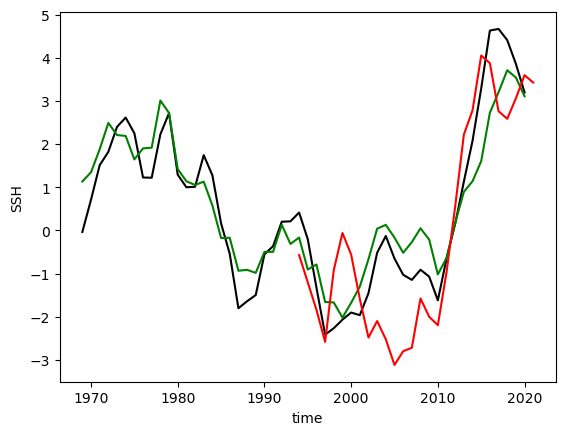

In [71]:
hr_regssh.rolling(time=3, center=True).mean().plot(c='k')
tmp.rolling(time=3, center=True).mean().plot(c='g')
alt_regssh.rename('SSH').rolling(time=3, center=True).mean().plot(c='r')

In [22]:
def lag_regress(x, y, lagx=0, lagy=0):
    x,y = xr.align(x,y)
    if lagx!=0:
        if lagx>0: x = x.shift(time = -lagx).isel(time=slice(0,-lagx))
        if lagx<0: x = x.shift(time = -lagx).isel(time=slice(-lagx,None))
    if lagy!=0:
        if lagy>0: y = y.shift(time = -lagy).isel(time=slice(0,-lagy))
        if lagy<0: y = y.shift(time = -lagy).isel(time=slice(-lagy,None))       
    x,y = xr.align(x,y)
    corr = xs.pearson_r(x,y,dim='time',skipna=True)
    slope = xs.linslope(x,y,dim='time',skipna=True)
    neff = xs.effective_sample_size(x,y,dim='time',skipna=True)
    pval = xs.pearson_r_eff_p_value(x,y,dim='time')
    stats = xr.DataArray(['corr','slope','pval','neff'],dims="stat",name="stat")
    xrout = xr.concat([corr,slope,pval,neff],dim=stats)
    return xrout

def concat_regress(x, y, lagyrange):
    """ y is a field being regressed onto x, with y lagging by lagyrange 
    """
    results = []
    lag = xr.DataArray([i for i in lagyrange],dims='lag',name='lag')
    for i in lagyrange:
        result = lag_regress(x,y,lagy=i)
        results.append(result)
    return xr.concat(results,dim=lag)

In [23]:
lagrange = range(-10,3,1)
lag = xr.DataArray([i for i in lagrange],dims='lag',name='lag')
lag

<xarray.DataArray 'lag' (lag: 13)>
array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2])
Dimensions without coordinates: lag

In [36]:
ydat = sshann.load()

In [37]:
%%time
xdat = hr_regssh.rolling(time=3, center=True).mean()
#ydat = sshann.chunk(dict(time=-1))
# Note xdat leads/lags for positive/negative lags
ssh_reg_egom = concat_regress(xdat,ydat,lagrange)

/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xs

CPU times: user 3min 21s, sys: 1min 11s, total: 4min 33s
Wall time: 5min 4s


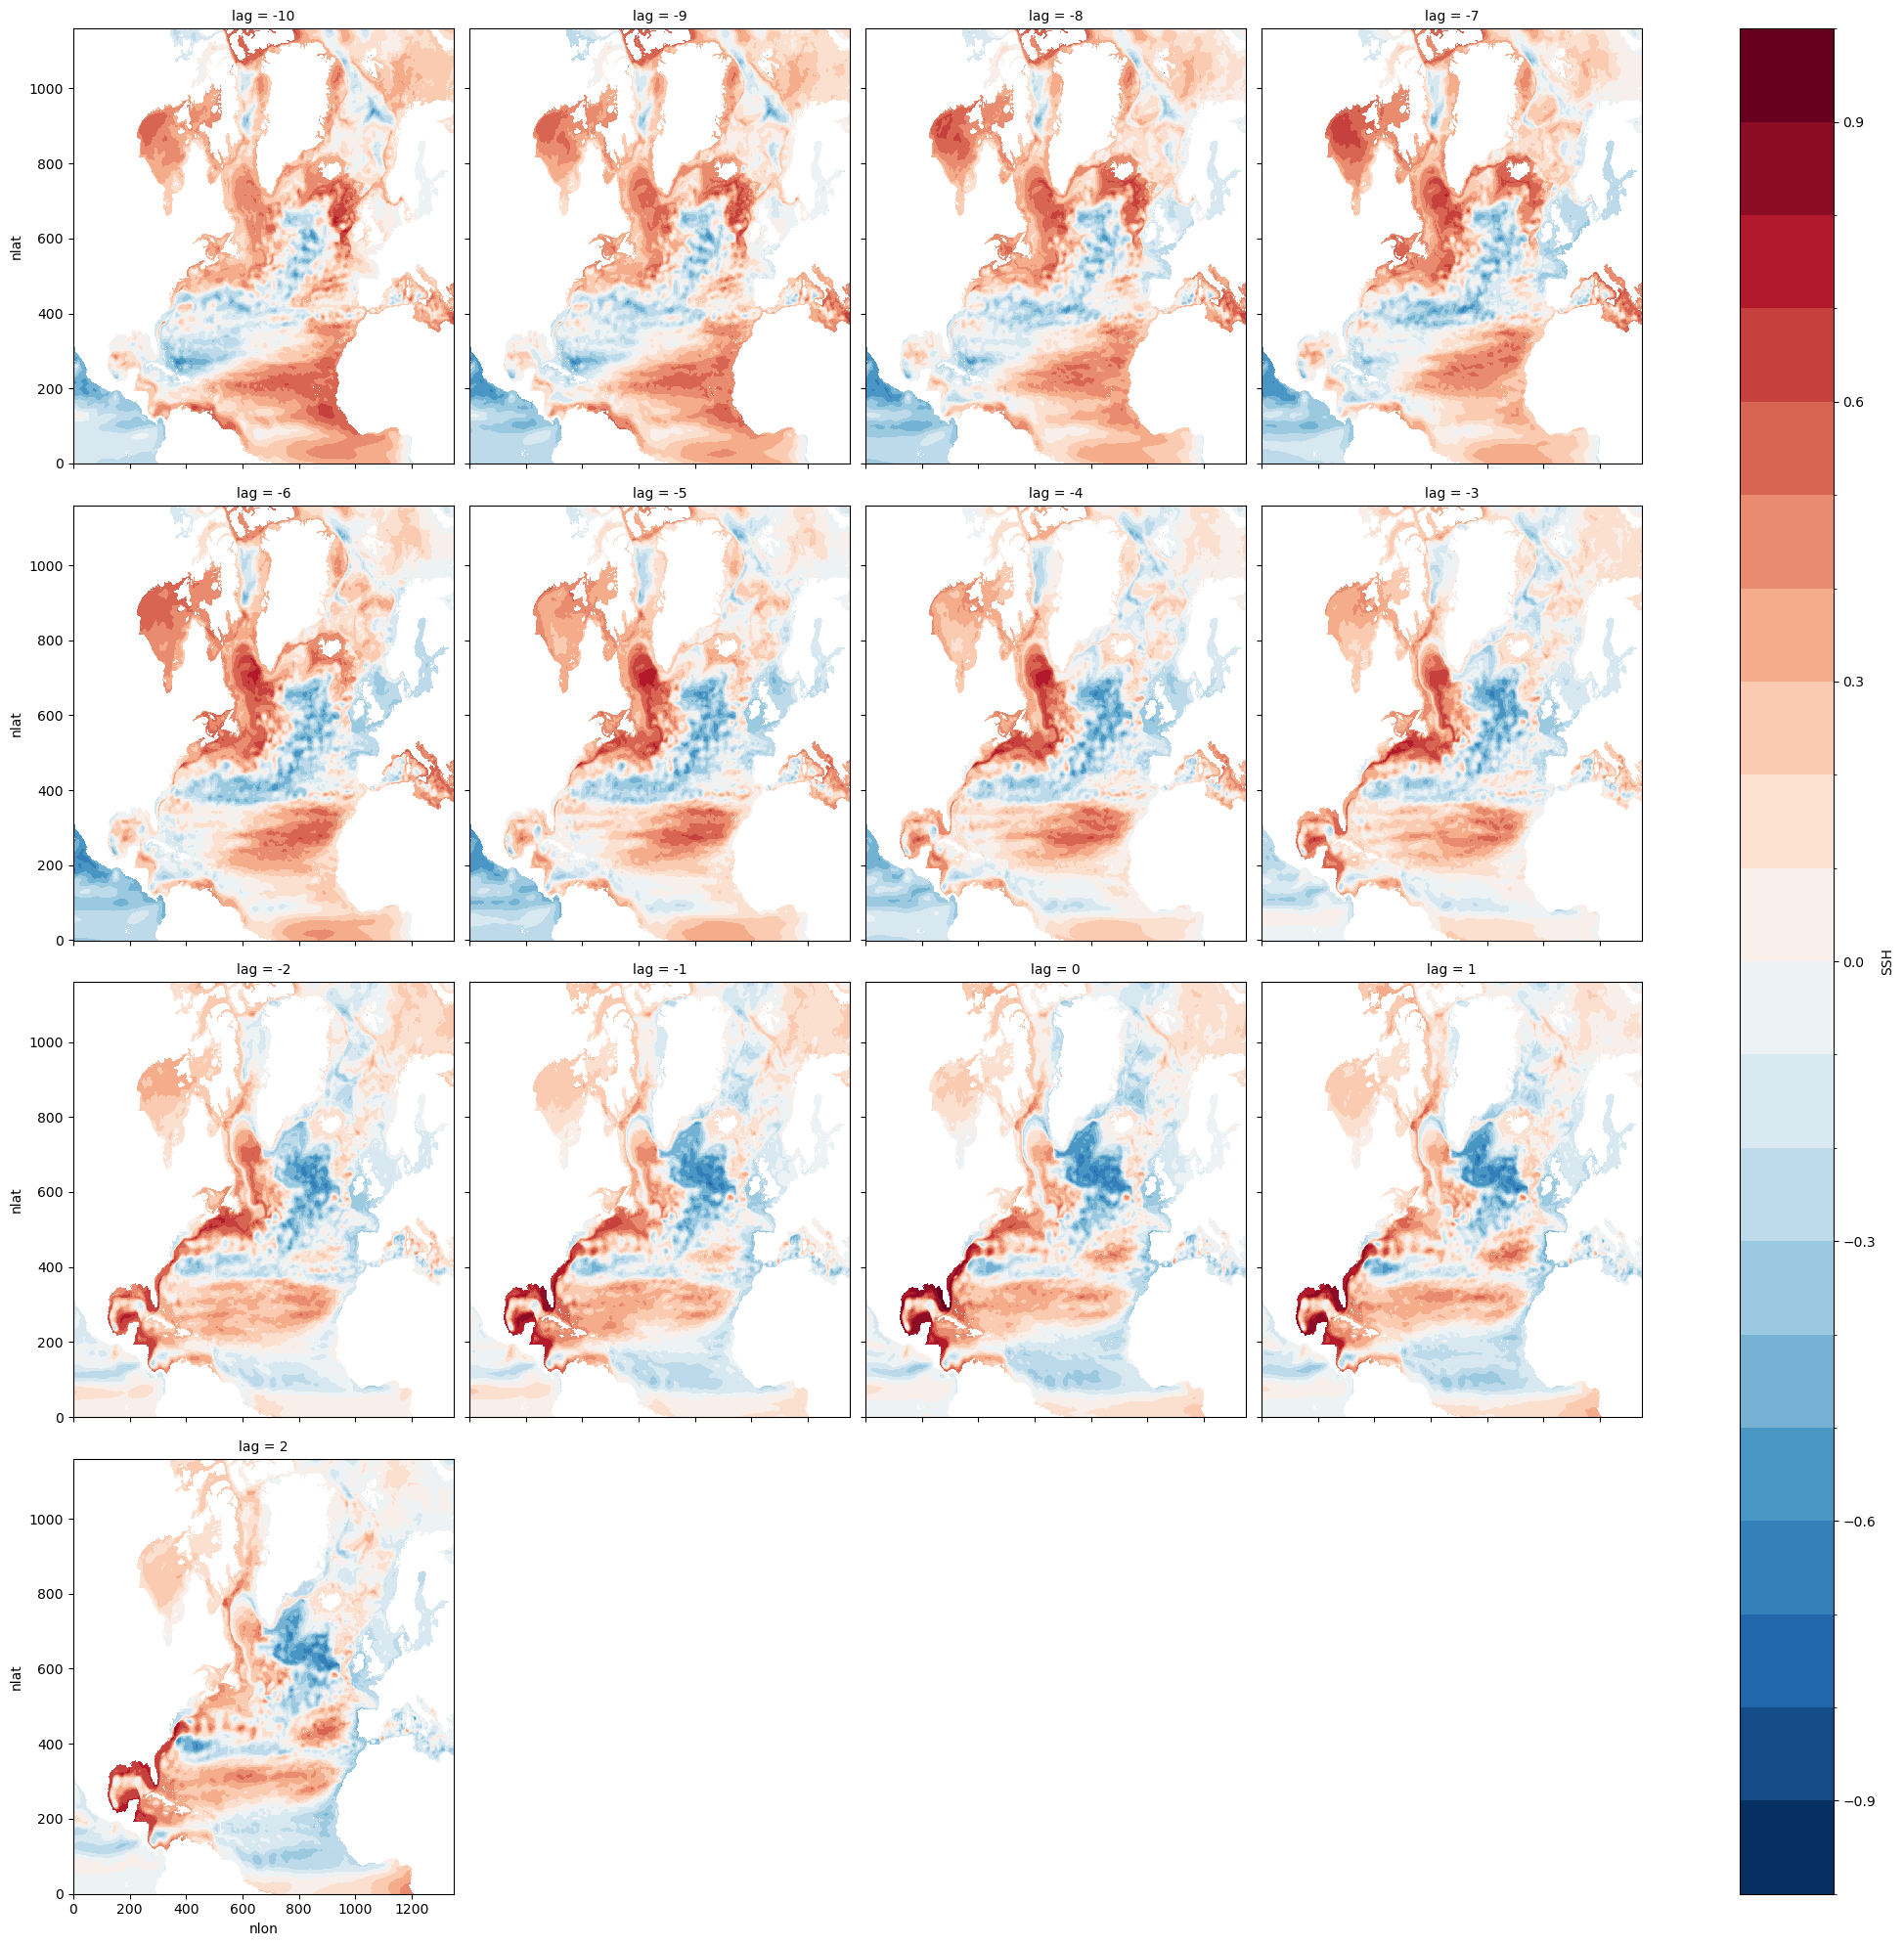

In [38]:
levs = np.arange(0,21)*0.1-1
ssh_reg_egom.sel(stat='corr').plot.imshow(col='lag',size=5,levels=levs,col_wrap=4)

In [40]:
np.arange(0,21,1)*0.1 - 1

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [44]:
ssh_reg_egom

<xarray.DataArray 'SSH' (lag: 13, stat: 4, nlat: 1160, nlon: 1350)>
array([[[[-1.89797384e-01, -1.89751557e-01, -1.90246376e-01, ...,
                      nan,             nan,             nan],
         [-1.89859790e-01, -1.90395655e-01, -1.90388139e-01, ...,
                      nan,             nan,             nan],
         [-1.90350674e-01, -1.90428322e-01, -1.91020961e-01, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
           2.06636774e-01,  2.02465658e-01,  2.10465529e-01],
         [            nan,             nan,             nan, ...,
           1.98200419e-01,  2.06816934e-01,  2.02525172e-01],
         [            nan,             nan,             nan, ...,
           1.98887739e-01,  1.95193005e-01,  2.03411566e-01]],

        [[-3.40934617e-01, -3.41289387e-01, -3.41709725e-01, ...,
                      nan,             nan,             nan],
         [-3.43891880e-01, -3.44375278e-01, -3.44783662e-01, ...,
                      nan,             nan,             nan],
         [-3.46809533e-01, -3.47355174e-01, -3.47932214e-01, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 3.40000000e+01,  3.40000000e+01,  3.40000000e+01, ...,
                      nan,             nan,             nan],
         [ 3.50000000e+01,  3.50000000e+01,  3.50000000e+01, ...,
                      nan,             nan,             nan],
         [ 3.50000000e+01,  3.50000000e+01,  3.50000000e+01, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
           2.70000000e+01,  2.70000000e+01,  2.60000000e+01],
         [            nan,             nan,             nan, ...,
           2.60000000e+01,  2.60000000e+01,  2.60000000e+01],
         [            nan,             nan,             nan, ...,
           2.60000000e+01,  2.60000000e+01,  2.60000000e+01]]]])
Coordinates:
    TLONG    (nlat, nlon) float64 -110.0 -109.8 -109.8 ... 59.66 59.69 59.73
    TLAT     (nlat, nlon) float64 -3.148 -3.148 -3.148 ... 71.48 71.44 71.41
  * stat     (stat) <U5 'corr' 'slope' 'pval' 'neff'
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2
Dimensions without coordinates: nlat, nlon

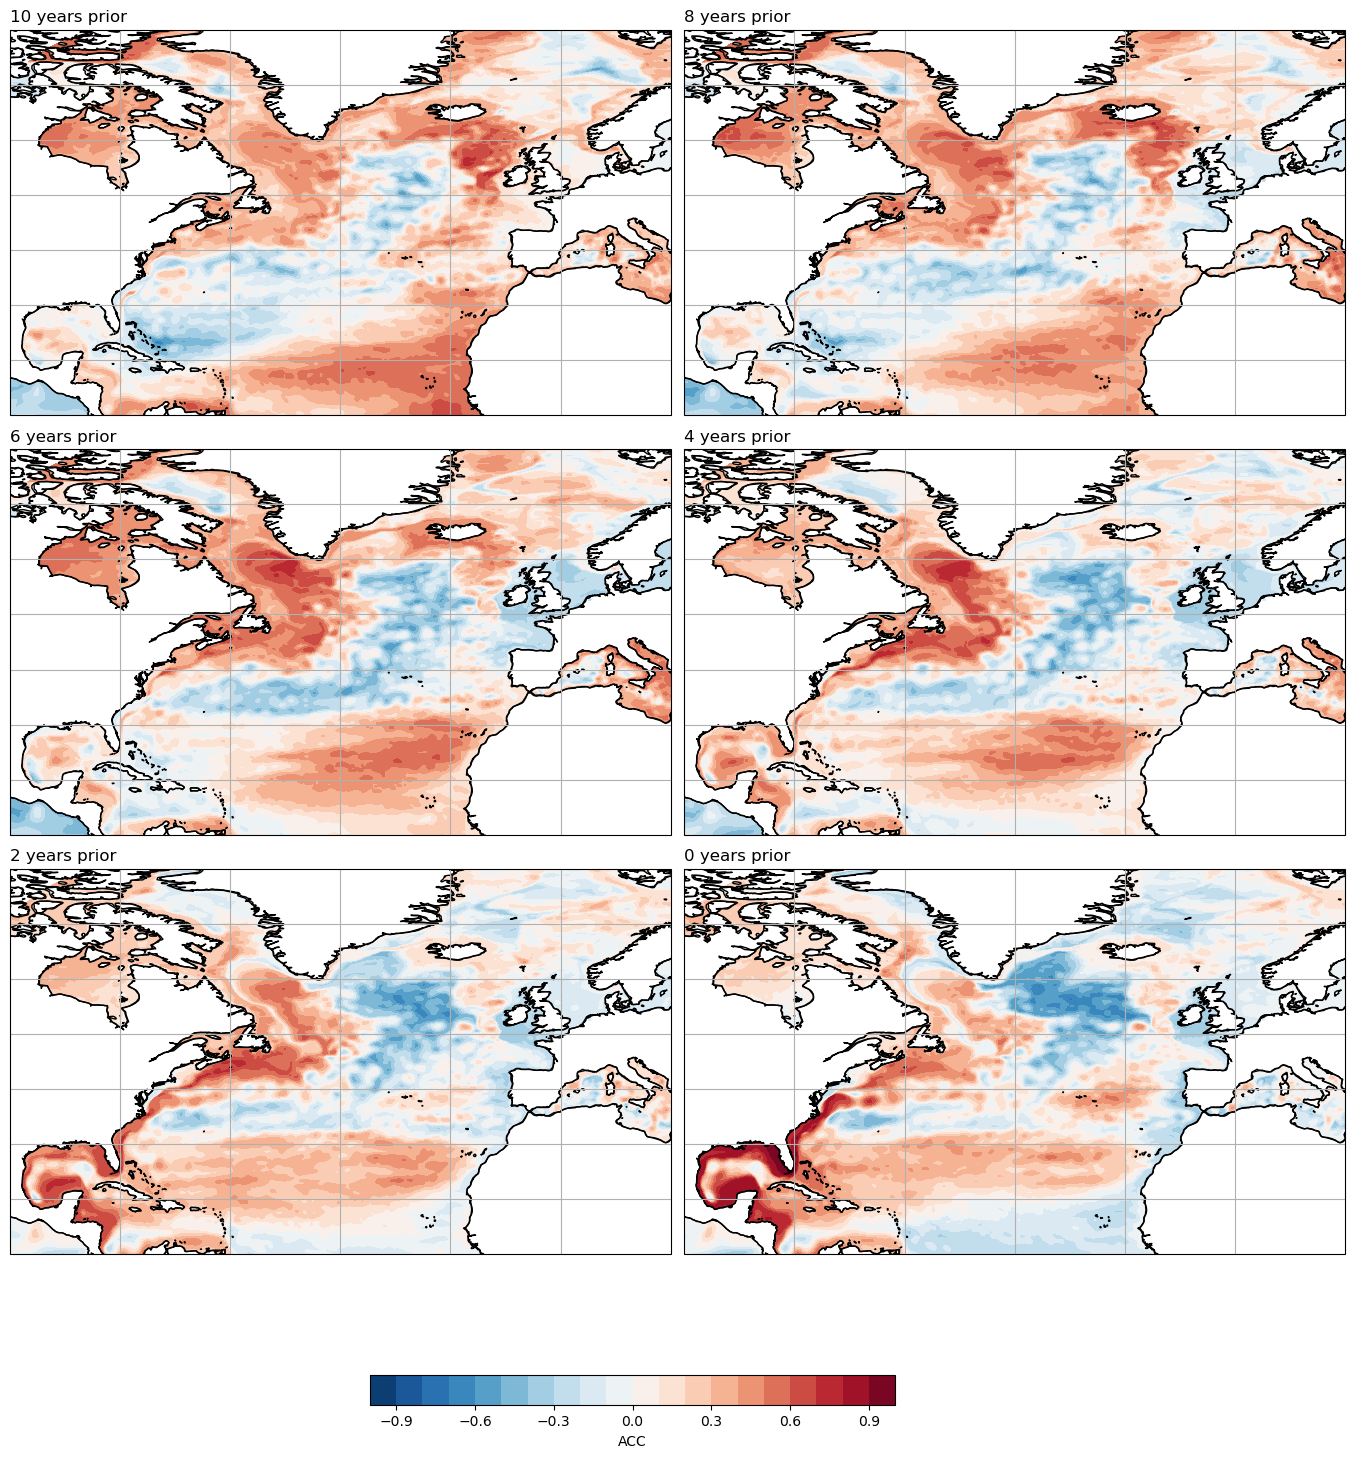

In [56]:
fontsize=12
colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 15))
nrow = 3
ncol = 2
nplot = nrow*ncol

corrlevs = np.arange(0,21,1)*0.1 - 1

for i in range(nplot):
    ax = fig.add_subplot(nrow, ncol, i+1, projection=proj1)
    thislag = -10+i*2
    tmp = ssh_reg_egom.sel(lag=thislag).sel(stat='corr')
    cntr = ax.contourf(hr_lon, hr_lat, tmp, levels=corrlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='neither')
    ax.coastlines(resolution='50m')
    ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
    ax.set_title('{} years prior'.format(-thislag),fontsize=fontsize, loc='left')
    ax.coastlines()
    extent = [-100,20, 10, 80]
    ax.set_extent(extent,crs=ccrs.PlateCarree())

fig.tight_layout()
fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax = fig.add_axes([0.25, 0.06, 0.35, 0.02])
fig.colorbar(cntr, cax=cbar_ax, orientation='horizontal',label='ACC')

plt.savefig('HRFOSI_SSH_regress_FWC.png')